In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import sys, os
from pathlib import Path

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import preprocess_data as ppd
import scenario_generation as sg

from scipy.stats import ks_2samp


import importlib

# Load test data predictions

In [2]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from typing import Iterable, Any, Tuple, Dict


# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score, balanced_accuracy_score, accuracy_score
from pathlib import Path


# Custom models
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import preprocess_data as ppd
import GAMinferenceModels_V2 as gam_models

In [3]:
folder_name = "2022_2023_test_periods_highReg"
spline_version = '_5sALL_'

In [4]:
states_only = []
filter_states = False

In [5]:
full_model_results = {}

for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/full{spline_version}/'), desc="Full Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue

    type_sim = csv_file.replace('.csv','').split('_')[-2]
    if type_sim != 'test':
        continue

    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/full{spline_version}/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    full_model_results[state_name] = results_data

Ar_model_results = {}
ar_model_general_results = pd.read_csv(f'../Results/GAM/{folder_name}/AR{spline_version}/GAM_Ar_results_test.csv', parse_dates=['Datetime_UTC'])
ar_model_general_results['pAA'] = 1-ar_model_general_results['pAD']-ar_model_general_results['pAO']
ar_model_general_results['pDD'] = 1- ar_model_general_results['pDA']
ar_model_general_results['pOO'] = 1- ar_model_general_results['pOA']

for state in full_model_results.keys():
    state_ar_results = ar_model_general_results[ar_model_general_results['State'] == state].reset_index(drop=True)
    Ar_model_results[state] = state_ar_results

As_model_results = {}
for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/As{spline_version}/'), desc="AS Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue
    type_sim = csv_file.replace('.csv','').split('_')[-2]
    if type_sim != 'test':
        continue
    if state_name not in full_model_results:
        continue

    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/As{spline_version}/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    As_model_results[state_name] = results_data

LogisticReg_model_results = {}

for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/LogisticReg/'), desc="Logistic Regression Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue
    type_sim = csv_file.replace('.csv','').split('_')[-2]
    if type_sim != 'test':
        continue
    if state_name not in full_model_results:
        continue

    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/LogisticReg/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    LogisticReg_model_results[state_name] = results_data


naive_model_results = {}
for csv_file in tqdm(os.listdir(f'../Results/GAM/{folder_name}/Naive_model/'), desc="Naive Model Results"):
    if not csv_file.endswith('.csv'):
        continue
    state_name = csv_file.replace('.csv','').split('_')[-1]
    if filter_states and (state_name not in states_only):
        continue
    if state_name not in full_model_results:
        continue
    results_data = pd.read_csv(os.path.join(f'../Results/GAM/{folder_name}/Naive_model/', csv_file), parse_dates=['Datetime_UTC'])
    # results_data = results_data.loc[results_data['State'] == state_name].reset_index(drop=True)

    full_res = full_model_results[state_name]
    assert len(set(full_res['Datetime_UTC']).difference(set(results_data['Datetime_UTC'])))==0, "Datetime_UTC do not match between full model and naive model results"
    results_data = results_data.merge(full_res[['Datetime_UTC','Stress']], on='Datetime_UTC', how='left')
    results_data['pAA'] = 1-results_data['pAD']-results_data['pAO']
    results_data['pDD'] = 1- results_data['pDA']
    results_data['pOO'] = 1- results_data['pOA']
    naive_model_results[state_name] = results_data

Naive Model Results: 100%|██████████| 47/47 [00:03<00:00, 11.87it/s]


In [6]:
models2evaluate = {
    'M': full_model_results,
    'AR': Ar_model_results,
    'AS': As_model_results,
    'LR': LogisticReg_model_results,
    'Naive': naive_model_results
}

# Per generator validation

In [7]:
technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']

## Data and results

### Historical scenarios

In [8]:
test_failures_df = pd.read_csv("../Data/hourly/hourly_failure_test_dataset_2022_2023.csv", parse_dates=['Datetime_UTC'])


In [16]:
historical_scenarios_per_state = defaultdict(lambda: defaultdict(pd.DataFrame)) # state -> generator_id -> scenarios

for state in tqdm(test_failures_df['State'].unique(), desc="Extracting historical scenarios per state"):
    state_failures = test_failures_df[test_failures_df['State'] == state]
    state_failures = state_failures[state_failures['Technology'].isin(technologies)].reset_index(drop=True)
    for gen_id in state_failures['UnitID'].unique():
        gen_failures = state_failures[state_failures['UnitID'] == gen_id].copy()
        gen_failures[['Datetime_UTC', 'Gen_state']].copy().reset_index(drop=True)
        historical_scenarios_per_state[state.upper()][gen_id] = gen_failures

Extracting historical scenarios per state: 100%|██████████| 55/55 [01:47<00:00,  1.95s/it]


### Generated scenarios

In [10]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_test_dataset_2022_2023.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]




_, test_scenario_generation_data, feature_names_gen, target_columns_gen, integer_encoding_gen = ppd.preprocess_data(failure_data_path="../Data/hourly/hourly_failure_dataset_compressed.csv",
                                                                weather_data_path=weather_data_file,
                                                                power_load_data_path=power_load_file,
                                                                feature_names=feature_names_base+['State'],
                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                state_one_hot=True,
                                                                initial_MC_state_filter="all",
                                                                final_MC_state_target="all",
                                                                technology_filter=technologies,
                                                                test_periods=test_periods
                                                                )
if 'Initial_gen_state' in feature_names_gen:
    feature_names_gen.remove('Initial_gen_state')
if 'Final_gen_state' in feature_names_gen:
    feature_names_gen.remove('Final_gen_state')
test_scenario_generation_data = test_scenario_generation_data[['Datetime_UTC']+feature_names_gen].drop_duplicates().copy()

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']


In [25]:
def get_historical_initial_state(region, generator_id, datetime, historical_scenarios_per_state):
    state_scenarios = historical_scenarios_per_state.get(region, None)
    if state_scenarios is None:
        print(f"No historical data for region {region}. Defaulting to 'A' for generator {generator_id}.")
        return 'A'  # default to 'A' if no historical data for this region
    gen_scenarios = state_scenarios.get(generator_id, pd.DataFrame())
    if gen_scenarios.empty:
        print(f"No historical data for generator {generator_id} in region {region}. Defaulting to 'A'.")
        return 'A'  # default to 'A' if no historical data for this generator
    initial_state = gen_scenarios[gen_scenarios['Datetime_UTC'] <= datetime].sort_values('Datetime_UTC').iloc[-1]['Gen_state']
    return initial_state

In [26]:
scenarios_inputs_by_state, generators_per_state = sg.get_scenario_inputs(test_scenario_generation_data, test_failures_df)

scenarios_inputs_by_state_new = {}
generators_per_state_new = {}
for state, val in scenarios_inputs_by_state.items():
    scenarios_inputs_by_state_new[state.upper()] = val

for state, val in generators_per_state.items():
    val = val.loc[val['Technology'].isin(technologies)].reset_index(drop=True)
    val['Start_state'] = val.apply(lambda row: get_historical_initial_state(state.upper(), row['UnitID'], row['Start_date'], historical_scenarios_per_state), axis=1)
    generators_per_state_new[state.upper()] = val

scenarios_inputs_by_state = scenarios_inputs_by_state_new
generators_per_state = generators_per_state_new

Getting generators by state: 100%|██████████| 55/55 [01:46<00:00,  1.93s/it]


No historical data for region BRITISH COLUMBIA. Defaulting to 'A' for generator nan.
No historical data for region RHODE ISLAND. Defaulting to 'A' for generator nan.
No historical data for region QUEBEC. Defaulting to 'A' for generator nan.
No historical data for region ONTARIO. Defaulting to 'A' for generator nan.
No historical data for region NEW HAMPSHIRE. Defaulting to 'A' for generator nan.


In [30]:
importlib.reload(sg)

<module 'scenario_generation' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/scenario_generation.py'>

In [31]:
N = 10 # Number of scenario generated for each generator and each time step

generated_scenarios_by_state = defaultdict(lambda: defaultdict(dict)) # {model_name: {state: scenarios_per_gen}} where scenarios_per_gen is a dict {unit_id: [scenarios]} and scenarios is a list of dataframes with columns ['Datetime_UTC', 'Gen_state'] and length equal to the number of scenarios generated for this unit_id

for model_name, model in models2evaluate.items():
    # generated_scenarios_by_state[model_name] = {}
    print(f"Processing model: {model_name}")

    for i, state in tqdm(enumerate(scenarios_inputs_by_state.keys()), total=len(scenarios_inputs_by_state), desc="Generating scenarios"):

        # print(f"Generating scenarios for state: {state}, model: {model_name}")

        probs_df = model.get(state, None)
        if probs_df is None:
            print(f"No probability dataframe found for state: {state}, model: {model_name}")
            continue
        probs_df = probs_df.copy()
        probs_df.drop_duplicates(subset=['Datetime_UTC'], inplace=True)

        covariates_inputs_df = scenarios_inputs_by_state[state]
        generators_data_df = generators_per_state[state]
        generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

        scenarios_per_gen = sg.generate_unavailable_capacity_scenario_per_gen(covariates_inputs_df,
                                                                                generators_data_df,
                                                                                # transition_model=model,
                                                                                probs_df=probs_df,
                                                                                # transition_prob_models['Frequency_Model'],
                                                                                # models_states[state],
                                                                                num_scenarios=1,
                                                                                min_scenarios_per_gen=N,
                                                                                )
        scenarios_per_gen = {unit_id:[s[['Datetime_UTC', 'Gen_state']] for s in scenarios] for unit_id, scenarios in scenarios_per_gen.items()}
        generated_scenarios_by_state[model_name][state] = scenarios_per_gen


Processing model: M


Generating scenarios:  55%|█████▌    | 26/47 [02:20<01:09,  3.29s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: M


Generating scenarios: 100%|██████████| 47/47 [04:09<00:00,  5.31s/it]


Processing model: AR


Generating scenarios:  55%|█████▌    | 26/47 [02:21<01:09,  3.31s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: AR


Generating scenarios: 100%|██████████| 47/47 [04:11<00:00,  5.35s/it]


Processing model: AS


Generating scenarios:  55%|█████▌    | 26/47 [02:22<01:09,  3.31s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: AS


Generating scenarios: 100%|██████████| 47/47 [04:11<00:00,  5.36s/it]


Processing model: LR


Generating scenarios:  55%|█████▌    | 26/47 [02:22<01:10,  3.33s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: LR


Generating scenarios: 100%|██████████| 47/47 [04:12<00:00,  5.38s/it]


Processing model: Naive


Generating scenarios:  55%|█████▌    | 26/47 [02:22<01:09,  3.33s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: Naive


Generating scenarios: 100%|██████████| 47/47 [04:12<00:00,  5.38s/it]


## 

## Analysis

### Dwell time

In [32]:
historical_dwell_times = defaultdict(list) # generator state -> list of dwell times in hours

for state, gen_scenarios in historical_scenarios_per_state.items():
    for gen_id, scenarios_df in gen_scenarios.items():
        for gen_state in scenarios_df['Gen_state'].unique():
            state_gen_scenarios = scenarios_df.copy()
            state_gen_scenarios['Gen_state'] = state_gen_scenarios['Gen_state']==gen_state
            state_gen_scenarios['start'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==1
            state_gen_scenarios['end'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==-1
            state_gen_scenarios['start_time'] = state_gen_scenarios['Datetime_UTC'].where(state_gen_scenarios['start'])
            state_gen_scenarios['end_time'] = state_gen_scenarios['Datetime_UTC'].where(state_gen_scenarios['end'])
            start_times = state_gen_scenarios['start_time'].dropna().values
            end_times = state_gen_scenarios['end_time'].dropna().values
            if start_times.size > 0 and end_times.size > 0:
                if start_times[0] > end_times[0]:
                    if end_times.size > 1:
                        end_times = end_times[1:]
                    else:
                        continue

                if end_times.size > 0 and (start_times[-1] > end_times[-1]):
                    start_times = start_times[:-1]
                dwell_times = (end_times - start_times).astype('timedelta64[h]').astype(int)
                
                historical_dwell_times[gen_state].extend(dwell_times)

In [33]:
historical_dwell_times = defaultdict(list) # generator state -> list of dwell times in hours

for state, gen_scenarios in historical_scenarios_per_state.items():
    for gen_id, scenarios_df in gen_scenarios.items():
        for gen_state in scenarios_df['Gen_state'].unique():
            state_gen_scenarios = scenarios_df.copy()
            state_gen_scenarios['Gen_state'] = state_gen_scenarios['Gen_state']==gen_state
            state_gen_scenarios['start'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==1
            state_gen_scenarios['end'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==-1
            start_idxs = state_gen_scenarios.index[state_gen_scenarios['start']].tolist()
            end_idxs = state_gen_scenarios.index[state_gen_scenarios['end']].tolist()
            if len(start_idxs) > 0 and len(end_idxs) > 0:
                if start_idxs[0] > end_idxs[0]:
                    if len(end_idxs) > 1:
                        end_idxs = end_idxs[1:]
                    else:
                        continue

                if len(end_idxs) > 0 and (start_idxs[-1] > end_idxs[-1]):
                    start_idxs = start_idxs[:-1]
                dwell_times = (np.array(end_idxs) - np.array(start_idxs)).tolist()
                
                historical_dwell_times[gen_state].extend(dwell_times)

In [34]:
generated_dwell_times = defaultdict(lambda: defaultdict(list)) # model -> generator state -> list of dwell times in hours

for model_name, model_scenarios in generated_scenarios_by_state.items():
    for state, scenarios_per_gen in tqdm(model_scenarios.items(), total=len(model_scenarios), desc=f"Processing generated scenarios for model: {model_name}"):
        for gen_id, scenarios_list in scenarios_per_gen.items():
            for scenario_df in scenarios_list:
                for gen_state in scenario_df['Gen_state'].unique():
                    state_gen_scenarios = scenario_df.copy()
                    state_gen_scenarios['Gen_state'] = state_gen_scenarios['Gen_state']==gen_state
                    state_gen_scenarios['start'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==1
                    state_gen_scenarios['end'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==-1
                    state_gen_scenarios['start_time'] = state_gen_scenarios['Datetime_UTC'].where(state_gen_scenarios['start'])
                    state_gen_scenarios['end_time'] = state_gen_scenarios['Datetime_UTC'].where(state_gen_scenarios['end'])
                    start_times = state_gen_scenarios['start_time'].dropna().values
                    end_times = state_gen_scenarios['end_time'].dropna().values
                    if start_times.size > 0 and end_times.size > 0:
                        if start_times[0] > end_times[0]:
                            if end_times.size > 1:
                                end_times = end_times[1:]
                            else:
                                continue

                        if end_times.size > 0 and (start_times[-1] > end_times[-1]):
                            start_times = start_times[:-1]
                        dwell_times = (end_times - start_times).astype('timedelta64[h]').astype(int)
                        
                        generated_dwell_times[model_name][gen_state].extend(dwell_times)
                    # state_gen_scenarios['dwell_time'] = (state_gen_scenarios['end_time'] - state_gen_scenarios['start_time']).dt.total_seconds() / 3600
                    # dwell_times = state_gen_scenarios['dwell_time'].dropna().tolist()
                    # generated_dwell_times[model_name][gen_state].extend(dwell_times)


Processing generated scenarios for model: Naive: 100%|██████████| 46/46 [01:41<00:00,  2.21s/it]


In [35]:
generated_dwell_times = defaultdict(lambda: defaultdict(list)) # model -> generator state -> list of dwell times in hours

for model_name, model_scenarios in generated_scenarios_by_state.items():
    for state, scenarios_per_gen in tqdm(model_scenarios.items(), total=len(model_scenarios), desc=f"Processing generated scenarios for model: {model_name}"):
        for gen_id, scenarios_list in scenarios_per_gen.items():
            for scenario_df in scenarios_list:
                for gen_state in scenario_df['Gen_state'].unique():
                    state_gen_scenarios = scenario_df.copy()
                    state_gen_scenarios['Gen_state'] = state_gen_scenarios['Gen_state']==gen_state
                    state_gen_scenarios['start'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==1
                    state_gen_scenarios['end'] = (state_gen_scenarios['Gen_state']-state_gen_scenarios['Gen_state'].shift(1))==-1
                    start_idxs = state_gen_scenarios.index[state_gen_scenarios['start']].tolist()
                    end_idxs = state_gen_scenarios.index[state_gen_scenarios['end']].tolist()
                    if len(start_idxs) > 0 and len(end_idxs) > 0:
                        if start_idxs[0] > end_idxs[0]:
                            if len(end_idxs) > 1:
                                end_idxs = end_idxs[1:]
                            else:
                                continue

                        if len(end_idxs) > 0 and (start_idxs[-1] > end_idxs[-1]):
                            start_idxs = start_idxs[:-1]
                        dwell_times = (np.array(end_idxs) - np.array(start_idxs)).tolist()
                        
                        
                        generated_dwell_times[model_name][gen_state].extend(dwell_times)
                    # state_gen_scenarios['dwell_time'] = (state_gen_scenarios['end_time'] - state_gen_scenarios['start_time']).dt.total_seconds() / 3600
                    # dwell_times = state_gen_scenarios['dwell_time'].dropna().tolist()
                    # generated_dwell_times[model_name][gen_state].extend(dwell_times)


Processing generated scenarios for model: Naive: 100%|██████████| 46/46 [01:27<00:00,  1.90s/it]


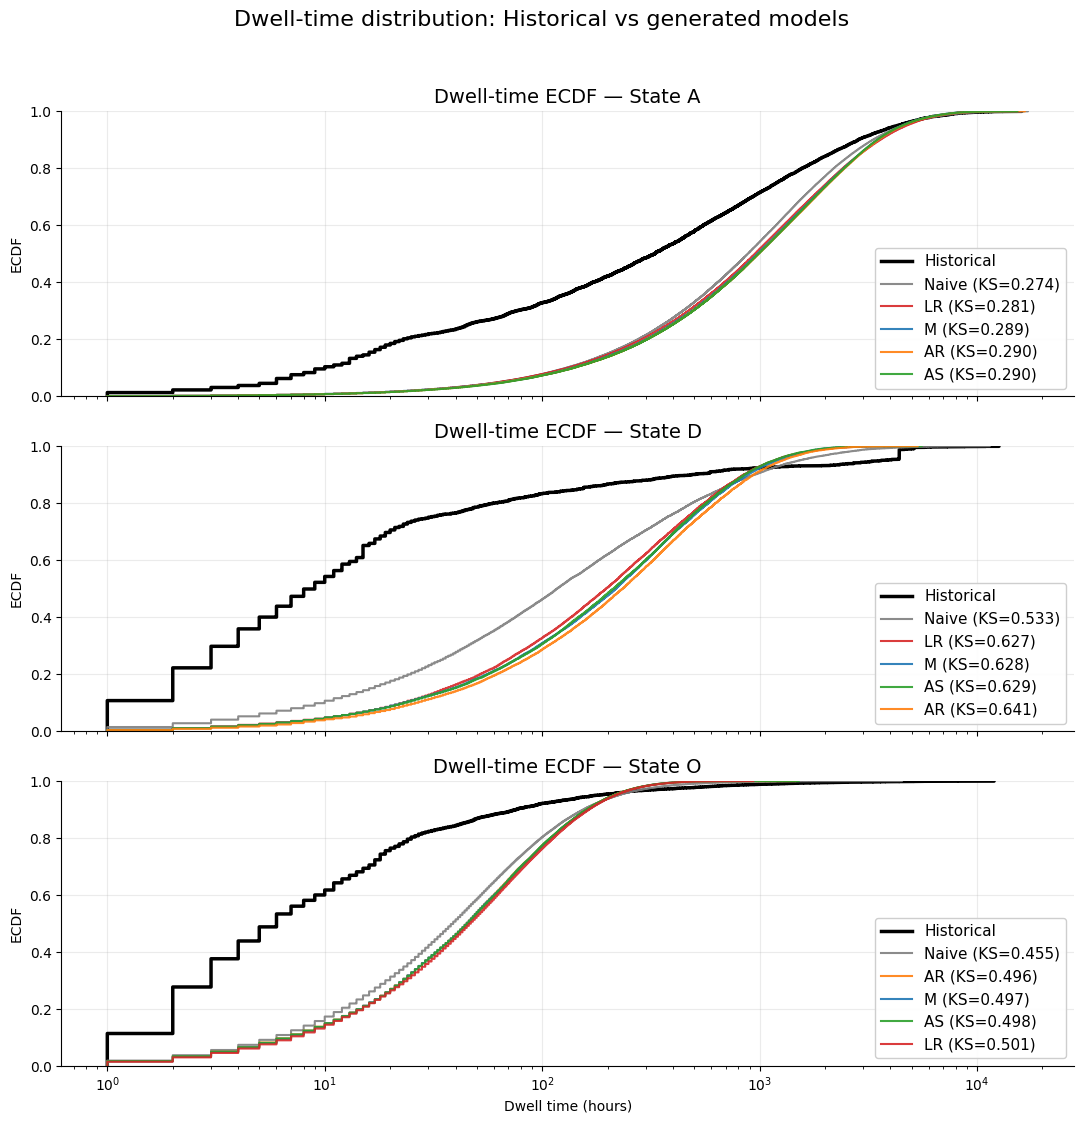

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from matplotlib.lines import Line2D

def plot_dwelltime_ecdf_by_state(
    historical_dwell_times,
    generated_dwell_times,
    model_colors,
    *,
    states_order=None,
    state_labels=None,
    models_order=None,
    xscale="log",
    figsize=(10, 10),
    font_base=12,
    hist_color="black",
    hist_lw=2.5,
    model_lw=2.0,
    model_alpha=0.9,
):
    """
    One subplot per generator state. In each subplot:
      - Historical ECDF (black)
      - ECDF of each model (colored)
      - Legend: model name + KS statistic vs historical

    historical_dwell_times: dict[state -> list/array]
    generated_dwell_times: dict[model -> dict[state -> list/array]]
    model_colors: dict[model -> color]
    """

    # ---- ordering ----
    if states_order is None:
        states_order = list(historical_dwell_times.keys())
    if state_labels is None:
        default_map = {0: "A", 1: "D", 2: "O", "A": "A", "D": "D", "O": "O"}
        state_labels = {s: default_map.get(s, str(s)) for s in states_order}

    if models_order is None:
        # keep only models that appear in both dicts, preserve model_colors order if possible
        models_order = [m for m in model_colors.keys() if m in generated_dwell_times]
        if not models_order:
            models_order = list(generated_dwell_times.keys())

    n_rows = len(states_order)
    fig, axs = plt.subplots(n_rows, 1, figsize=figsize, sharex=True, sharey=True)
    axs = np.atleast_1d(axs)

    plt.rcParams.update({
        "font.size": font_base,
        "axes.titlesize": font_base + 2,
        "axes.labelsize": font_base + 1,
        "xtick.labelsize": font_base,
        "ytick.labelsize": font_base,
        "legend.fontsize": font_base - 1,
    })

    for r, gen_state in enumerate(states_order):
        ax = axs[r]

        # ---- clean arrays ----
        hv = np.asarray(historical_dwell_times.get(gen_state, []), dtype=float)
        hv = hv[np.isfinite(hv) & (hv > 0)]
        hv = np.sort(hv)

        # ---- axes style ----
        ax.grid(True, alpha=0.25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_ylim(0, 1.0)
        ax.set_xscale(xscale)

        # ---- plot historical ----
        legend_handles = []
        if hv.size > 0:
            Fh = np.arange(1, len(hv) + 1) / len(hv)
            ax.step(hv, Fh, where="post", color=hist_color, lw=hist_lw)
            legend_handles.append(Line2D([0], [0], color=hist_color, lw=hist_lw, label="Historical"))
        else:
            ax.text(0.5, 0.5, "No historical data", transform=ax.transAxes,
                    ha="center", va="center", color="0.5")
            # still proceed, but KS stats will be n/a

        # ---- compute KS stats first ----
        model_info = []  # (model, gv_sorted, ks_stat)

        for model in models_order:
            gv = np.asarray(generated_dwell_times.get(model, {}).get(gen_state, []), dtype=float)
            gv = gv[np.isfinite(gv) & (gv > 0)]
            gv = np.sort(gv)

            if gv.size == 0 or hv.size == 0:
                ks_stat = np.nan
            else:
                ks_stat = ks_2samp(gv, hv).statistic

            model_info.append((model, gv, ks_stat))

        # ---- sort by increasing KS (nan last) ----
        model_info.sort(key=lambda x: (np.inf if not np.isfinite(x[2]) else x[2]))

        # ---- plot models in sorted order ----
        for model, gv, ks_stat in model_info:
            c = model_colors.get(model, "0.5")

            if gv.size > 0:
                Fg = np.arange(1, len(gv) + 1) / len(gv)
                ax.step(gv, Fg, where="post", color=c, lw=model_lw, alpha=model_alpha)

            ks_txt = "n/a" if not np.isfinite(ks_stat) else f"{ks_stat:.3f}"
            legend_handles.append(
                Line2D([0], [0], color=c, lw=model_lw, alpha=model_alpha,
                    label=f"{model} (KS={ks_txt})")
            )

        # ---- titles/labels ----
        ax.set_title(f"Dwell-time ECDF — State {state_labels.get(gen_state, gen_state)}")
        ax.set_ylabel("ECDF")

        # ---- legend inside each subplot (best readability) ----
        ax.legend(handles=legend_handles, loc="lower right", frameon=True, framealpha=0.95)

    axs[-1].set_xlabel("Dwell time (hours)")
    fig.suptitle("Dwell-time distribution: Historical vs generated models", y=1.02, fontsize=font_base + 4)
    plt.tight_layout()
    plt.show()


# Example:
model_colors = {
    'M': 'tab:blue',
    'AR': 'tab:orange',
    'AS': 'tab:green',
    'LR': 'tab:red',
    'Naive': 'tab:gray',
}
plot_dwelltime_ecdf_by_state(historical_dwell_times, generated_dwell_times, model_colors,
                            states_order=['A','D','U'], state_labels={0:"A",1:"D","U":"O"},
                            figsize=(11, 11), font_base=12, model_lw=1.5)

# Simultaneous failures

In [7]:
technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']

## Data and results

### Historical scenarios

In [8]:
test_failures_df = pd.read_csv("../Data/hourly/hourly_failure_test_dataset_2022_2023.csv", parse_dates=['Datetime_UTC'])

In [9]:
historical_scenarios_per_state = defaultdict(lambda: defaultdict(pd.DataFrame)) # state -> generator_id -> scenarios

for state in tqdm(test_failures_df['State'].unique(), desc="Extracting historical scenarios per state"):
    state_failures = test_failures_df[test_failures_df['State'] == state]
    state_failures = state_failures[state_failures['Technology'].isin(technologies)].reset_index(drop=True)
    for gen_id in state_failures['UnitID'].unique():
        gen_failures = state_failures[state_failures['UnitID'] == gen_id].copy()
        gen_failures[['Datetime_UTC', 'Gen_state']].copy().reset_index(drop=True)
        historical_scenarios_per_state[state][gen_id] = gen_failures

Extracting historical scenarios per state: 100%|██████████| 55/55 [01:46<00:00,  1.93s/it]


### Generated scenarios

In [10]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_test_dataset_2022_2023.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]




_, test_scenario_generation_data, feature_names_gen, target_columns_gen, integer_encoding_gen = ppd.preprocess_data(failure_data_path="../Data/hourly/hourly_failure_dataset_compressed.csv",
                                                                weather_data_path=weather_data_file,
                                                                power_load_data_path=power_load_file,
                                                                feature_names=feature_names_base+['State'],
                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                state_one_hot=True,
                                                                initial_MC_state_filter="all",
                                                                final_MC_state_target="all",
                                                                technology_filter=technologies,
                                                                test_periods=test_periods
                                                                )
if 'Initial_gen_state' in feature_names_gen:
    feature_names_gen.remove('Initial_gen_state')
if 'Final_gen_state' in feature_names_gen:
    feature_names_gen.remove('Final_gen_state')
test_scenario_generation_data = test_scenario_generation_data[['Datetime_UTC']+feature_names_gen].drop_duplicates().copy()

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']


In [11]:
scenarios_inputs_by_state, generators_per_state = sg.get_scenario_inputs(test_scenario_generation_data, test_failures_df)

scenarios_inputs_by_state_new = {}
generators_per_state_new = {}
for state, val in scenarios_inputs_by_state.items():
    scenarios_inputs_by_state_new[state.upper()] = val

for state, val in generators_per_state.items():
    generators_per_state_new[state.upper()] = val

scenarios_inputs_by_state = scenarios_inputs_by_state_new
generators_per_state = generators_per_state_new

Getting generators by state: 100%|██████████| 55/55 [01:45<00:00,  1.92s/it]


In [12]:
N = 10 # Number of scenario generated for each generator and each time step

generated_scenarios_by_state = defaultdict(lambda: defaultdict(dict)) # {model_name: {state: scenarios_per_gen}} where scenarios_per_gen is a dict {unit_id: [scenarios]} and scenarios is a list of dataframes with columns ['Datetime_UTC', 'Gen_state'] and length equal to the number of scenarios generated for this unit_id

for model_name, model in models2evaluate.items():
    # generated_scenarios_by_state[model_name] = {}
    print(f"Processing model: {model_name}")

    for i, state in tqdm(enumerate(scenarios_inputs_by_state.keys()), total=len(scenarios_inputs_by_state), desc="Generating scenarios"):

        # print(f"Generating scenarios for state: {state}, model: {model_name}")

        probs_df = model.get(state, None)
        if probs_df is None:
            print(f"No probability dataframe found for state: {state}, model: {model_name}")
            continue
        probs_df = probs_df.copy()
        probs_df.drop_duplicates(subset=['Datetime_UTC'], inplace=True)

        covariates_inputs_df = scenarios_inputs_by_state[state]
        generators_data_df = generators_per_state[state]
        generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

        scenarios_per_gen = sg.generate_unavailable_capacity_scenario_per_gen(covariates_inputs_df,
                                                                                generators_data_df,
                                                                                # transition_model=model,
                                                                                probs_df=probs_df,
                                                                                # transition_prob_models['Frequency_Model'],
                                                                                # models_states[state],
                                                                                num_scenarios=1,
                                                                                min_scenarios_per_gen=N,
                                                                                )
        scenarios_per_gen = {unit_id:[s[['Datetime_UTC', 'Gen_state']] for s in scenarios] for unit_id, scenarios in scenarios_per_gen.items()}
        generated_scenarios_by_state[model_name][state] = scenarios_per_gen


Processing model: M


Generating scenarios:  55%|█████▌    | 26/47 [02:24<01:10,  3.36s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: M


Generating scenarios: 100%|██████████| 47/47 [04:15<00:00,  5.44s/it]


Processing model: AR


Generating scenarios:  55%|█████▌    | 26/47 [02:23<01:10,  3.37s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: AR


Generating scenarios: 100%|██████████| 47/47 [04:17<00:00,  5.47s/it]


Processing model: AS


Generating scenarios:  55%|█████▌    | 26/47 [02:27<01:10,  3.38s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: AS


Generating scenarios: 100%|██████████| 47/47 [04:19<00:00,  5.52s/it]


Processing model: LR


Generating scenarios:  55%|█████▌    | 26/47 [02:25<01:11,  3.40s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: LR


Generating scenarios: 100%|██████████| 47/47 [04:17<00:00,  5.48s/it]


Processing model: Naive


Generating scenarios:  55%|█████▌    | 26/47 [02:25<01:10,  3.37s/it]

No probability dataframe found for state: NEW HAMPSHIRE, model: Naive


Generating scenarios: 100%|██████████| 47/47 [04:18<00:00,  5.50s/it]


## Analysis

### Historical frequency of states

In [39]:
historical_frequencies = []

for state, gen_scenarios in historical_scenarios_per_state.items():
    # state_df = pd.concatenate(list(gen_scenarios.values()), axis=0)
    state_df = pd.concat(gen_scenarios.values())

    state_df = state_df.groupby(['Datetime_UTC', 'Gen_state']).size().reset_index(name='count').pivot(index='Datetime_UTC', columns='Gen_state', values='count').fillna(0).reset_index()
    state_df['State'] = state
    for gen_state in ['A', 'D', 'U']:
        if gen_state not in state_df.columns:
            state_df[gen_state] = 0
    state_df['num_generators'] = state_df[['A', 'D', 'U']].sum(axis=1)
    for gen_state in ['A', 'D', 'U']:
        state_df[f'f_{gen_state}'] = state_df[gen_state] / state_df['num_generators']
    historical_frequencies.append(state_df[['Datetime_UTC', 'State', 'f_A', 'f_D', 'f_U', 'num_generators']].copy())

historical_frequencies = pd.concat(historical_frequencies, axis=0).reset_index(drop=True)

### Generated frequencies of states

In [40]:
generated_frequencies = defaultdict(list) # model -> list of dataframes with columns ['Datetime_UTC', 'State', 'f_A', 'f_D', 'f_U', 'num_generators']

for model_name, model_scenarios in generated_scenarios_by_state.items():
    for state, scenarios_per_gen in tqdm(model_scenarios.items(), total=len(model_scenarios), desc=f"Processing generated scenarios for model: {model_name}"):
        for j in range(len(scenarios_per_gen[list(scenarios_per_gen.keys())[0]])): # for each scenario index (assuming all gens have same number of scenarios)
            state_scenarios = []
            for gen_id, scenarios_list in scenarios_per_gen.items():
                state_scenarios.append(scenarios_list[j])
            scenarios_state = pd.concat(state_scenarios, axis=0)
            state_df = scenarios_state.groupby(['Datetime_UTC', 'Gen_state']).size().reset_index(name='count').pivot(index='Datetime_UTC', columns='Gen_state', values='count').fillna(0).reset_index()
            state_df['State'] = state
            for gen_state in ['A', 'D', 'U']:
                if gen_state not in state_df.columns:
                    state_df[gen_state] = 0
            state_df['num_generators'] = state_df[['A', 'D', 'U']].sum(axis=1)
            for gen_state in ['A', 'D', 'U']:
                state_df[f'f_{gen_state}'] = state_df[gen_state] / state_df['num_generators']
            generated_frequencies[model_name].append(state_df[['Datetime_UTC', 'State', 'f_A', 'f_D', 'f_U', 'num_generators']].copy())

Processing generated scenarios for model: Naive: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


### Plots

In [41]:
def weighted_ecdf(x, w):
    """
    Returns sorted x and weighted ECDF.
    """
    order = np.argsort(x)
    x_sorted = x[order]
    w_sorted = w[order]
    w_norm = w_sorted / w_sorted.sum()
    ecdf = np.cumsum(w_norm)
    return x_sorted, ecdf


def weighted_ks_distance(x1, w1, x2, w2):
    """
    Weighted KS distance between two 1D distributions.
    """
    x1s, F1 = weighted_ecdf(x1, w1)
    x2s, F2 = weighted_ecdf(x2, w2)

    grid = np.sort(np.unique(np.concatenate([x1s, x2s])))
    F1g = np.interp(grid, x1s, F1, left=0.0, right=1.0)
    F2g = np.interp(grid, x2s, F2, left=0.0, right=1.0)

    return np.max(np.abs(F1g - F2g))

model_colors = {
    'M': 'tab:blue',
    'AR': 'tab:orange',
    'AS': 'tab:green',
    'LR': 'tab:red',
    'Naive': 'tab:gray',
}

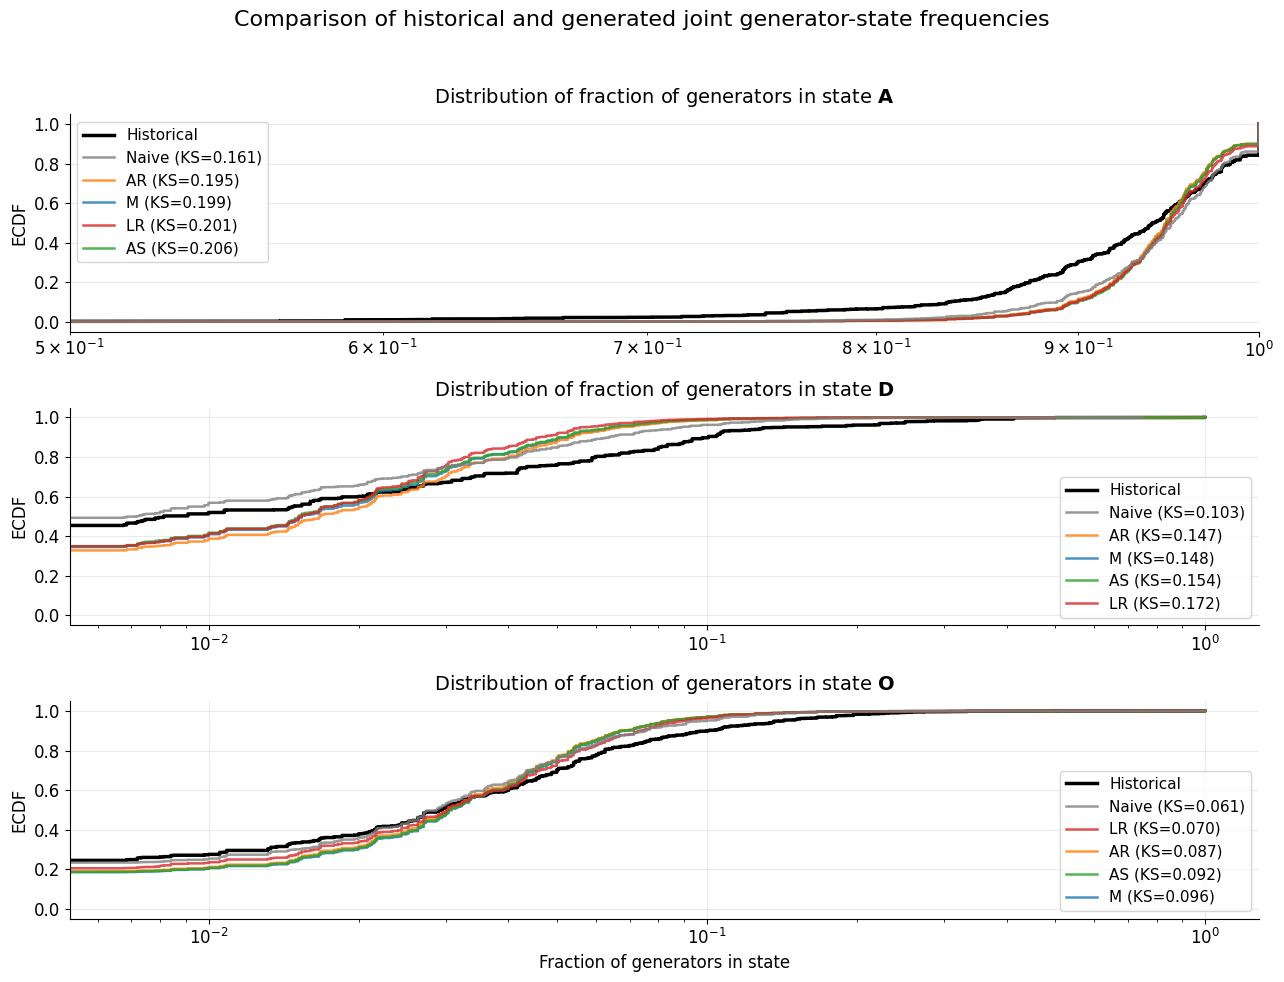

: 

In [ ]:
import matplotlib.pyplot as plt

def plot_state_fraction_ecdfs(
    historical_frequencies,
    generated_frequencies,
    gen_states=('A', 'D', 'U'),
    model_colors=None,
    figsize=(13, 10),
):
    if model_colors is None:
        model_colors = {}

    fig, axs = plt.subplots(len(gen_states), 1, figsize=figsize, sharex=False)

    for i, gen_state in enumerate(gen_states):
        ax = axs[i]

        # ---------- historical ----------
        hist_f = historical_frequencies[f"f_{gen_state}"].values
        hist_w = historical_frequencies["num_generators"].to_numpy(dtype=float)

        xh, Fh = weighted_ecdf(hist_f, hist_w)

        ax.step(
            xh, Fh,
            where="post",
            color="black",
            lw=2.5,
            label="Historical"
        )

        # ---------- generated models ----------
        ks_by_model = []

        for model_name, dfs in generated_frequencies.items():
            df = pd.concat(dfs, axis=0)

            f = df[f"f_{gen_state}"].values
            w = df["num_generators"].to_numpy(dtype=float)

            xs, Fs = weighted_ecdf(f, w)

            ks = weighted_ks_distance(hist_f, hist_w, f, w)
            ks_by_model.append((model_name, ks))

            ax.step(
                xs, Fs,
                where="post",
                lw=1.8,
                alpha=0.8,
                color=model_colors.get(model_name, "gray"),
                label=f"{model_name} (KS={ks:.3f})"
            )

        # ---------- formatting ----------
        ax.set_title(
            rf"Distribution of fraction of generators in state $\mathbf{{{gen_state if gen_state != 'U' else 'O'}}}$",
            fontsize=14,
            pad=8
        )

        ax.set_ylabel("ECDF", fontsize=12)
        ax.grid(True, alpha=0.25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.set_xscale("log")

        # order legend by increasing KS
        handles, labels = ax.get_legend_handles_labels()
        hist_handle = handles[labels.index("Historical")]
        hist_label = "Historical"

        model_entries = [
            (h, l) for h, l in zip(handles, labels) if l != "Historical"
        ]

        model_entries_sorted = sorted(
            model_entries,
            key=lambda x: float(x[1].split("KS=")[1].rstrip(")"))
        )

        handles_sorted = [hist_handle] + [h for h, _ in model_entries_sorted]
        labels_sorted  = [hist_label]  + [l for _, l in model_entries_sorted]

        ax.legend(
            handles_sorted,
            labels_sorted,
            fontsize=11,
            frameon=True,
            loc="lower right" if gen_state != 'A' else "upper left"
        )
        if gen_state == 'A':
            ax.set_xlim(0.5,1)

    axs[-1].set_xlabel("Fraction of generators in state", fontsize=12)

    fig.suptitle(
        "Comparison of historical and generated joint generator-state frequencies",
        fontsize=16,
        y=0.98
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_state_fraction_ecdfs(historical_frequencies, generated_frequencies, gen_states=['A', 'D', 'U'], model_colors=model_colors)

/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_61656/3638911466.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


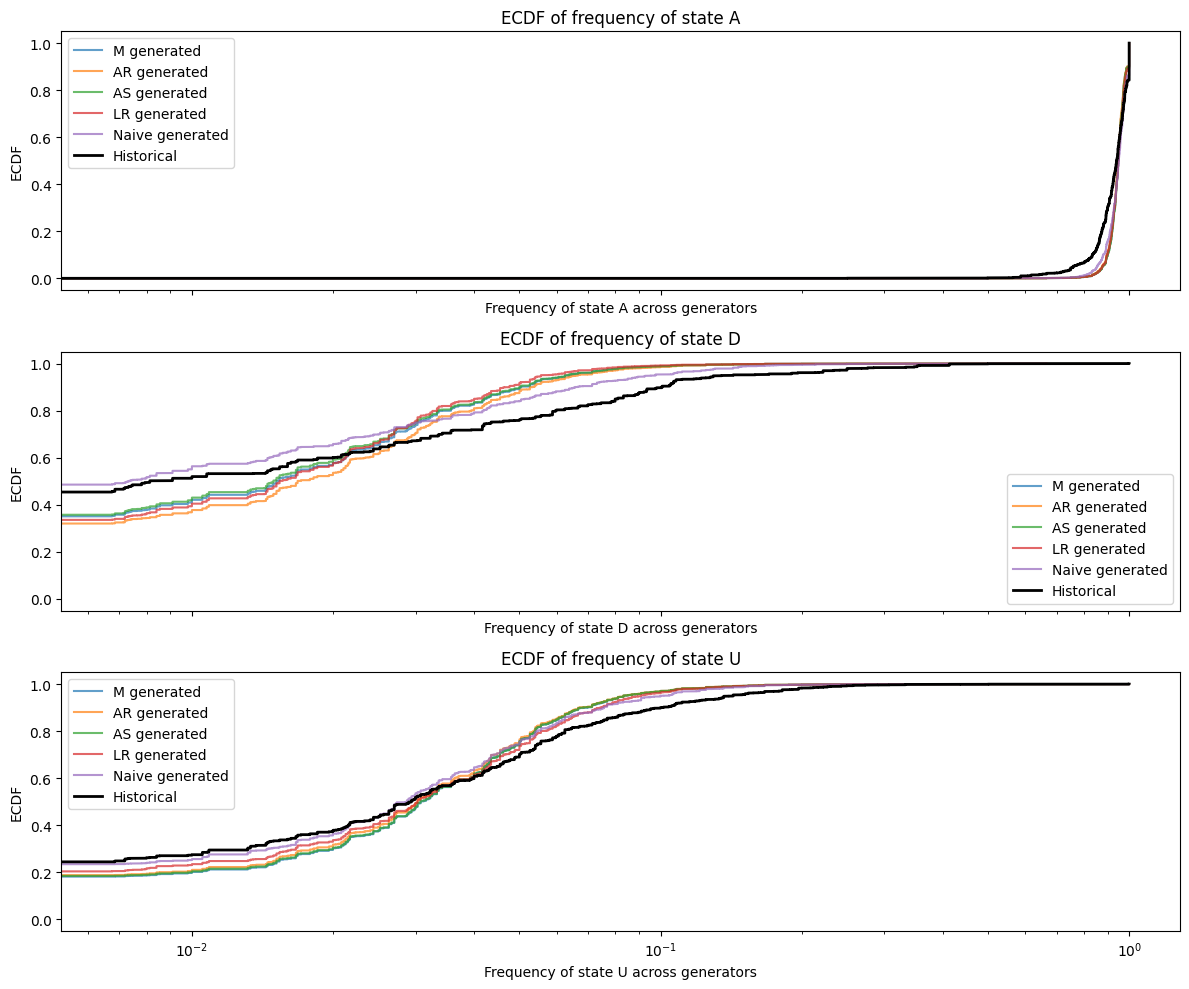

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for i, gen_state in enumerate(['A', 'D', 'U']):
    ax = axs[i]
    for model_name, state_dfs in generated_frequencies.items():
        model_generated_frequencies = pd.concat(state_dfs, axis=0)
        f = model_generated_frequencies[f'f_{gen_state}'].values
        w = model_generated_frequencies['num_generators'].to_numpy(dtype=int)
        order = np.argsort(f)
        w = w / w.sum()  # normalize to sum to 1
        model_ecdf = np.cumsum(w[order])
        model_f = f[order]
        
        ax.step(model_f, model_ecdf, where="post", label=f"{model_name} generated", alpha=0.7)
    
    hist_f = historical_frequencies[f'f_{gen_state}'].values
    hist_w = historical_frequencies['num_generators'].to_numpy(dtype=int)
    hist_w = hist_w / hist_w.sum()  # normalize to sum to 1
    order = np.argsort(hist_f)

    hist_f = hist_f[order]
    hist_ecdf = np.cumsum(hist_w[order])
    ax.step(hist_f, hist_ecdf, where="post", label="Historical", color="black", lw=2)
    ax.set_title(f"ECDF of frequency of state {gen_state}")
    ax.set_xlabel(f"Frequency of state {gen_state} across generators")
    ax.set_ylabel("ECDF")
    ax.set_xscale("log")
    ax.legend()
plt.tight_layout()
plt.show()

/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_61656/2606001374.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


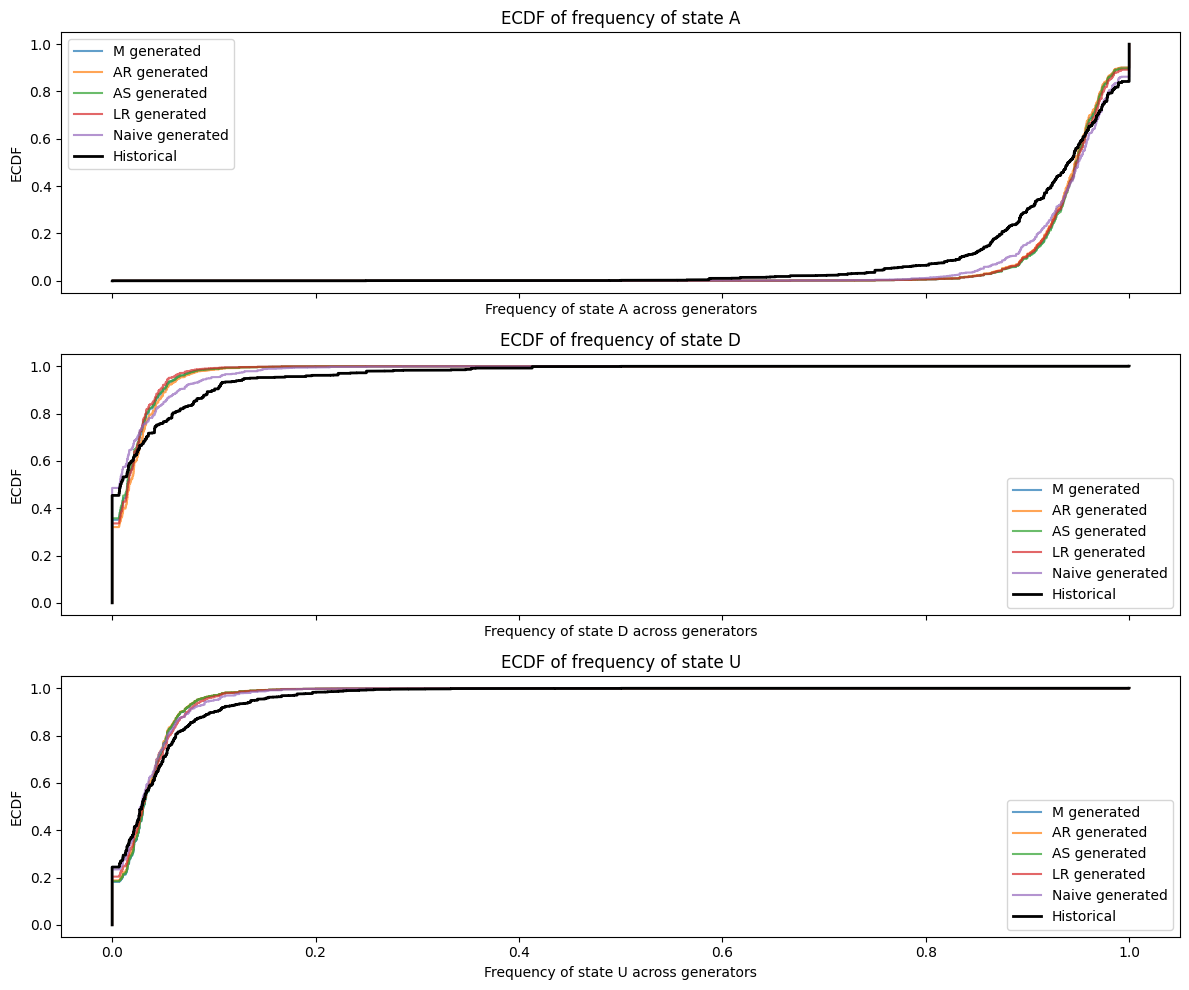

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for i, gen_state in enumerate(['A', 'D', 'U']):
    ax = axs[i]
    for model_name, state_dfs in generated_frequencies.items():
        model_generated_frequencies = pd.concat(state_dfs, axis=0)
        f = model_generated_frequencies[f'f_{gen_state}'].values
        w = model_generated_frequencies['num_generators'].to_numpy(dtype=int)
        order = np.argsort(f)
        w = w / w.sum()  # normalize to sum to 1
        model_ecdf = np.cumsum(w[order])
        model_f = f[order]
        
        ax.step(model_f, model_ecdf, where="post", label=f"{model_name} generated", alpha=0.7)
    
    hist_f = historical_frequencies[f'f_{gen_state}'].values
    hist_w = historical_frequencies['num_generators'].to_numpy(dtype=int)
    hist_w = hist_w / hist_w.sum()  # normalize to sum to 1
    order = np.argsort(hist_f)

    hist_f = hist_f[order]
    hist_ecdf = np.cumsum(hist_w[order])
    ax.step(hist_f, hist_ecdf, where="post", label="Historical", color="black", lw=2)
    ax.set_title(f"ECDF of frequency of state {gen_state}")
    ax.set_xlabel(f"Frequency of state {gen_state} across generators")
    ax.set_ylabel("ECDF")
    # ax.set_xscale("log")
    ax.legend()
plt.tight_layout()
plt.show()

# Historical scenarios construction

In [10]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_test_dataset_2022_2023.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]
technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']


In [11]:
test_failures_df = pd.read_csv("../Data/hourly/hourly_failure_test_dataset_2022_2023.csv", parse_dates=['Datetime_UTC'])

_, test_scenario_generation_data, feature_names_gen, target_columns_gen, integer_encoding_gen = ppd.preprocess_data(failure_data_path="../Data/hourly/hourly_failure_dataset_compressed.csv",
                                                                weather_data_path=weather_data_file,
                                                                power_load_data_path=power_load_file,
                                                                feature_names=feature_names_base+['State'],
                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                state_one_hot=True,
                                                                initial_MC_state_filter="all",
                                                                final_MC_state_target="all",
                                                                technology_filter=technologies,
                                                                test_periods=test_periods
                                                                )
if 'Initial_gen_state' in feature_names_gen:
    feature_names_gen.remove('Initial_gen_state')
if 'Final_gen_state' in feature_names_gen:
    feature_names_gen.remove('Final_gen_state')
test_scenario_generation_data = test_scenario_generation_data[['Datetime_UTC']+feature_names_gen].drop_duplicates().copy()

In [12]:
historical_scenario_by_state = {}
# for state in tqdm(models2evaluate['M'].keys(), desc="Aggregating historical scenarios by state"):
for state in tqdm(test_failures_df['State'].unique(), desc="Aggregating historical scenarios by state"):
    state_failures_df = test_failures_df[test_failures_df['State'] == state].copy()
    state_failures_df = state_failures_df[state_failures_df['Technology'].isin(technologies)].copy()
    state_scenario_df = sg.aggregate_scenario(state_failures_df)
    state_capital = state.upper()
    historical_scenario_by_state[state_capital] = state_scenario_df

Aggregating historical scenarios by state: 100%|██████████| 55/55 [01:47<00:00,  1.96s/it]


In [13]:
scenarios_inputs_by_state, generators_per_state = sg.get_scenario_inputs(test_scenario_generation_data, test_failures_df)

Getting generators by state: 100%|██████████| 55/55 [01:44<00:00,  1.90s/it]


In [14]:
scenarios_inputs_by_state_new = {}
generators_per_state_new = {}
for state, val in scenarios_inputs_by_state.items():
    scenarios_inputs_by_state_new[state.upper()] = val

for state, val in generators_per_state.items():
    generators_per_state_new[state.upper()] = val

scenarios_inputs_by_state = scenarios_inputs_by_state_new
generators_per_state = generators_per_state_new

In [ ]:
# states_to_plot = ['TEXAS']
states_to_plot = models2evaluate['M'].keys()

fig, axs = plt.subplots(len(states_to_plot), 1, figsize=(20,4*len(states_to_plot)))

for i, state in enumerate(states_to_plot):
    inputs_df = scenarios_inputs_by_state[state]
    if len(states_to_plot) == 1:
        ax = axs
    else:
        ax = axs[i]
    dt = inputs_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
    temp = inputs_df['Temperature'].to_numpy()*10

    historical_scenario_df = historical_scenario_by_state[state]
    historical_unavailable_capacity = historical_scenario_df['Unavailable_capacity (%)'].to_numpy()
    historical_dt = historical_scenario_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')

    ax.plot(dt, temp, color='tab:blue', label='Temperature')
    ax2 = ax.twinx()
    ax2.plot(historical_dt, historical_unavailable_capacity, color='tab:orange', label='Unavailable capacity (%)', alpha=0.6)

    ax.set_title(f'Temperature over Time in {state}')
    ax.set_xlabel('Datetime (UTC)')
    ax.set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Unavailable capacity (%)')


    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc='best')
plt.tight_layout()

# Scenario generation

In [ ]:
generated_scenarios_by_state = {}

for model_name, model in models2evaluate.items():
    generated_scenarios_by_state[model_name] = {}
    for state in states_to_plot:
        print(f"Generating scenarios for state: {state}, model: {model_name}")

        probs_df = model[state]
        covariates_inputs_df = scenarios_inputs_by_state[state]
        generators_data_df = generators_per_state[state]
        generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

        scenarios_per_gen = sg.generate_unavailable_capacity_scenario_per_gen(covariates_inputs_df,
                                                                                generators_data_df,
                                                                                # transition_model=model,
                                                                                probs_df=probs_df,
                                                                                # transition_prob_models['Frequency_Model'],
                                                                                # models_states[state],
                                                                                num_scenarios=2000,
                                                                                min_scenarios_per_gen=30,
                                                                                )

        generated_scenarios = sg.generate_unavailable_capacity_scenario(scenarios_per_gen,
                                                            num_scenarios=2000
                                                            )
        generated_scenarios_by_state[model_name][state] = generated_scenarios

In [24]:
states_to_plot = ['GEORGIA', 'MASSACHUSETTS', 'CALIFORNIA']

In [25]:
def KS_test(historical_scenario: pd.DataFrame, generated_scenarios: list[pd.DataFrame]):

    historical_vals = historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten()
    generated_vals = np.concatenate([scen['Unavailable_capacity (%)'].to_numpy().flatten() for scen in generated_scenarios])
    
    statistic, p_value = ks_2samp(historical_vals, generated_vals)
    return statistic, p_value

In [26]:
def quantile_coverage(
    historical_scenario: pd.DataFrame,
    generated_scenarios: list[pd.DataFrame],
    *,
    dt_col: str = "Datetime_UTC",
    val_col: str = "Unavailable_capacity (%)",
    lo: float = 0.05,
    hi: float = 0.95,
) -> float:
    if len(generated_scenarios) == 0:
        raise ValueError("generated_scenarios is empty")

    # --- historical as aligned series ---
    hist = (
        historical_scenario[[dt_col, val_col]]
        .drop_duplicates(subset=[dt_col])
        .set_index(dt_col)[val_col]
        .sort_index()
    )

    # --- stack generated values into (T, S) matrix aligned on hist index ---
    gen_mat = np.empty((len(hist), len(generated_scenarios)), dtype=float)

    for j, scen in enumerate(generated_scenarios):
        s = (
            scen[[dt_col, val_col]]
            .drop_duplicates(subset=[dt_col])
            .set_index(dt_col)[val_col]
            .reindex(hist.index)
        )
        gen_mat[:, j] = s.to_numpy()

    # If some timestamps were missing in some scenarios, drop those rows
    valid_rows = np.isfinite(hist.to_numpy()) & np.all(np.isfinite(gen_mat), axis=1)
    if not np.any(valid_rows):
        return float("nan")

    h = hist.to_numpy()[valid_rows]                 # (T_valid,)
    G = gen_mat[valid_rows, :]                      # (T_valid, S)

    # empirical quantile rank of hist among scenarios at each time
    q = (G <= h[:, None]).mean(axis=1)              # (T_valid,)

    return float(((q > lo) & (q < hi)).mean())

## Unconditional KS test

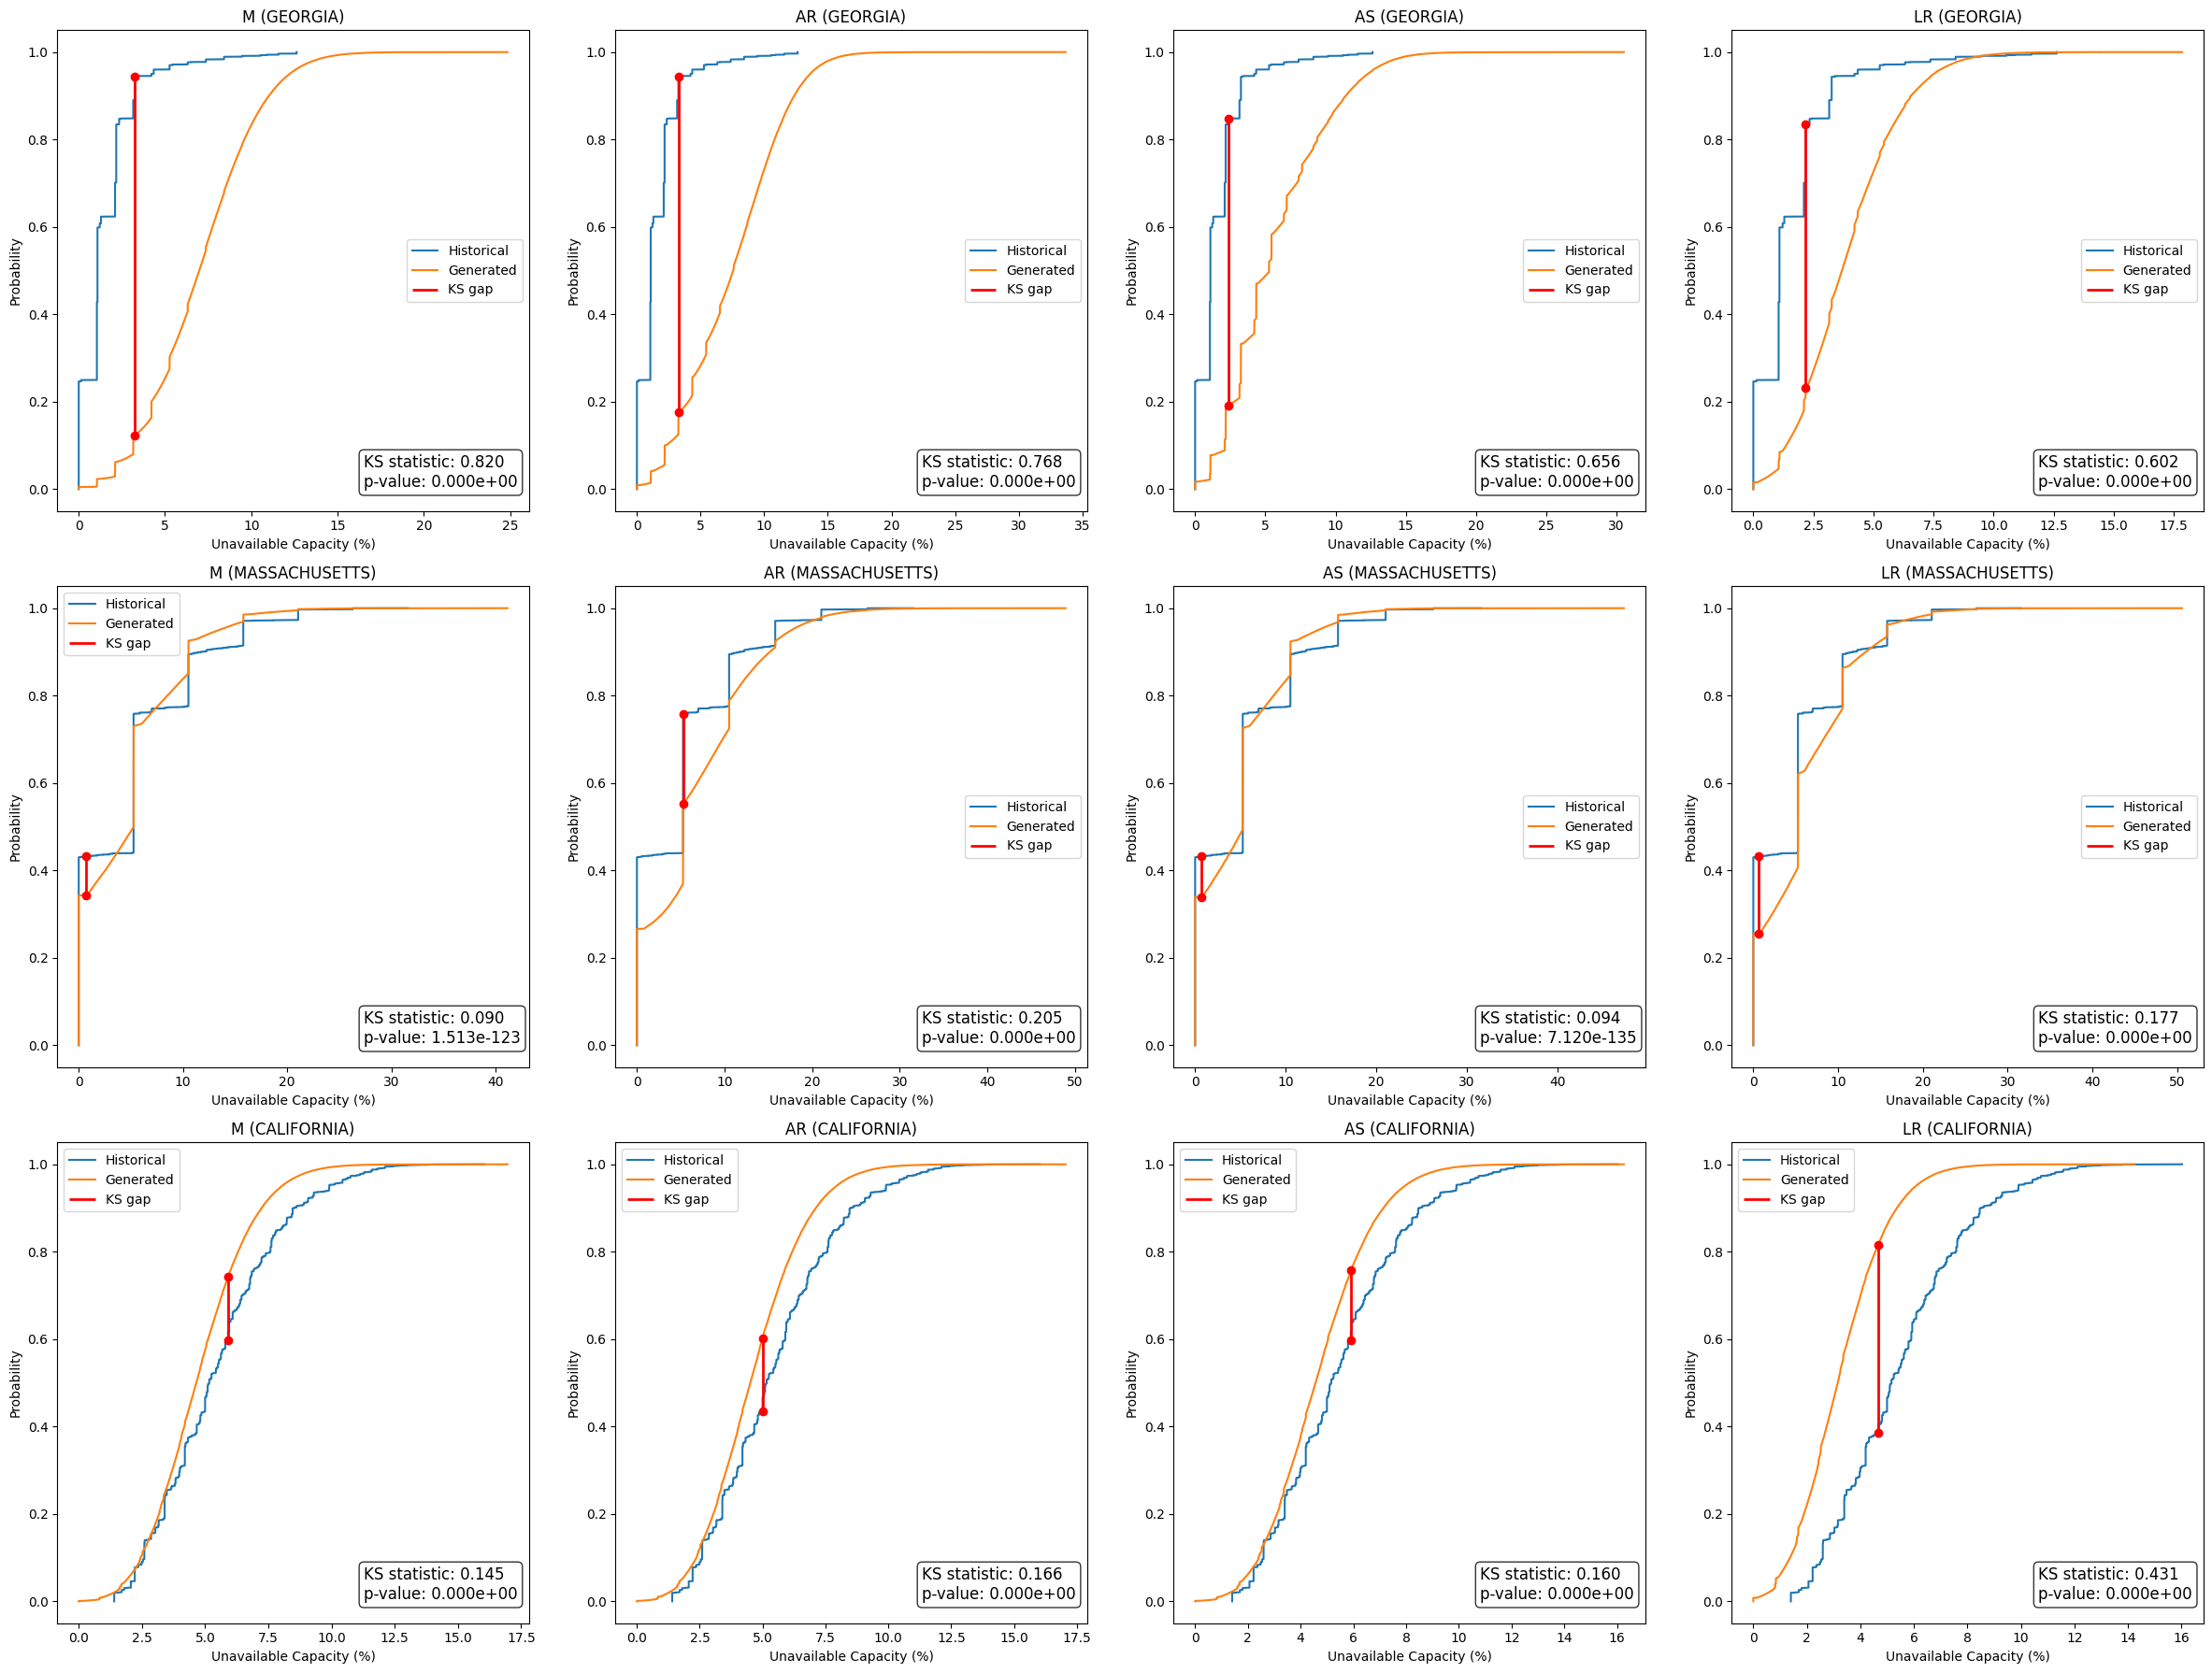

In [27]:
n_cols = len(models2evaluate)
n_rows = len(states_to_plot)
# n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))

for j, state in enumerate(states_to_plot):
    for i, (model_name, scenarios_model) in enumerate(generated_scenarios_by_state.items()):
        scenarios = scenarios_model[state]
        historical_scenario = historical_scenario_by_state[state]
        historical_vals = np.sort(historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten())

        generated_scenarios = scenarios#generated_scenarios_by_state[state]
        generated_vals = np.sort(np.concatenate([
            scen['Unavailable_capacity (%)'].to_numpy().flatten() 
            for scen in generated_scenarios
        ]))

        # Compute empirical CDFs
        F_hist = np.linspace(0, 1, len(historical_vals))
        F_gen  = np.linspace(0, 1, len(generated_vals))

        # For KS distance, evaluate both samples on a common grid
        combined = np.sort(np.concatenate([historical_vals, generated_vals]))

        # Empirical CDFs evaluated at combined x
        ecdf_hist = np.searchsorted(historical_vals, combined, side="right") / len(historical_vals)
        ecdf_gen  = np.searchsorted(generated_vals,  combined, side="right") / len(generated_vals)

        # KS statistic and location
        diff = np.abs(ecdf_hist - ecdf_gen)
        ks_stat = diff.max()
        x_ks = combined[np.argmax(diff)]

        # Two-sample KS test
        ks_test = ks_2samp(generated_vals, historical_vals)

        # ---------- Plot ----------
        
        ax = axs[j, i]

        ax.plot(historical_vals, F_hist, label='Historical', color='tab:blue')
        ax.plot(generated_vals, F_gen,  label='Generated', color='tab:orange')

        # Vertical red bar showing KS gap
        ax.vlines(x_ks, 
                ecdf_gen[np.argmax(diff)], 
                ecdf_hist[np.argmax(diff)], 
                color='red', linewidth=2, label='KS gap')

        # Mark the KS location with a dot
        ax.plot([x_ks], [ecdf_gen[np.argmax(diff)]], 'ro')
        ax.plot([x_ks], [ecdf_hist[np.argmax(diff)]], 'ro')

        # Title and axis labels
        # ax.set_title(f'Cumulative Distribution of data in {state} with model {model_name}')
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Unavailable Capacity (%)')
        ax.set_ylabel('Probability')

        # Annotate p-value
        ax.text(0.65, 0.05, 
                f"KS statistic: {ks_stat:.3f}\np-value: {ks_test.pvalue:.3e}",
                transform=ax.transAxes,
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

        ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [28]:
unconditional_ks_results = {'State':[], 'Model':[], 'KS_statistic':[], 'p_value':[]}
for model_name, scenarios_model in generated_scenarios_by_state.items():
    for state in tqdm(scenarios_model.keys(), desc=f"Unconditional KS test for model {model_name}"):
        scenarios = scenarios_model[state]
        historical_scenario = historical_scenario_by_state[state]

        ks_statistic, p_value = KS_test(historical_scenario, scenarios)

        unconditional_ks_results['State'].append(state)
        unconditional_ks_results['Model'].append(model_name)
        unconditional_ks_results['KS_statistic'].append(ks_statistic)
        unconditional_ks_results['p_value'].append(p_value)

Unconditional KS test for model LR: 100%|██████████| 16/16 [00:34<00:00,  2.14s/it]


In [29]:
unconditional_ks_results = pd.DataFrame(unconditional_ks_results)

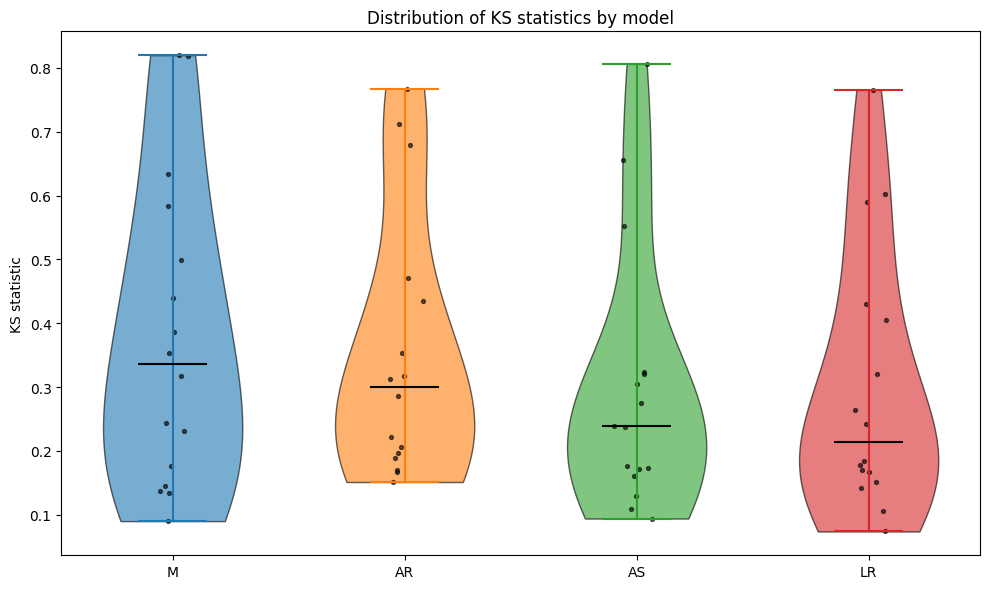

In [30]:
fig, ax = plt.subplots(figsize=(10,6))

for i, model_name in enumerate(models2evaluate.keys()):
    ks_model = unconditional_ks_results.loc[unconditional_ks_results['Model'] == model_name, 'KS_statistic'].values
    if len(ks_model) == 0:
        continue

    parts = ax.violinplot(ks_model, positions=[i], widths=0.6, showmeans=False, showmedians=True)

    # style violin body
    for pc in parts['bodies']:
        pc.set_facecolor(plt.cm.tab10(i % 10))
        pc.set_edgecolor('black')
        pc.set_alpha(0.6)

    # median line color
    if 'cmedians' in parts:
        parts['cmedians'].set_color('black')

    # overlay individual points (jittered)
    x = np.random.normal(i, 0.04, size=len(ks_model))
    ax.scatter(x, ks_model, color='k', s=8, alpha=0.6)

    # x ticks/labels and axis labels
    ax.set_xticks(list(range(len(models2evaluate))))
    ax.set_xticklabels(list(models2evaluate.keys()))
    ax.set_ylabel('KS statistic')
    ax.set_title('Distribution of KS statistics by model')
    plt.tight_layout()

## Temperature conditional KS

In [31]:
states_to_plot

['GEORGIA', 'MASSACHUSETTS', 'CALIFORNIA']

Evaluating model performance for state: GEORGIA, model: M
Evaluating model performance for state: GEORGIA, model: AR
Evaluating model performance for state: GEORGIA, model: AS
Evaluating model performance for state: GEORGIA, model: LR
Evaluating model performance for state: MASSACHUSETTS, model: M
Evaluating model performance for state: MASSACHUSETTS, model: AR
Evaluating model performance for state: MASSACHUSETTS, model: AS
Evaluating model performance for state: MASSACHUSETTS, model: LR
Evaluating model performance for state: CALIFORNIA, model: M
Evaluating model performance for state: CALIFORNIA, model: AR
Evaluating model performance for state: CALIFORNIA, model: AS
Evaluating model performance for state: CALIFORNIA, model: LR


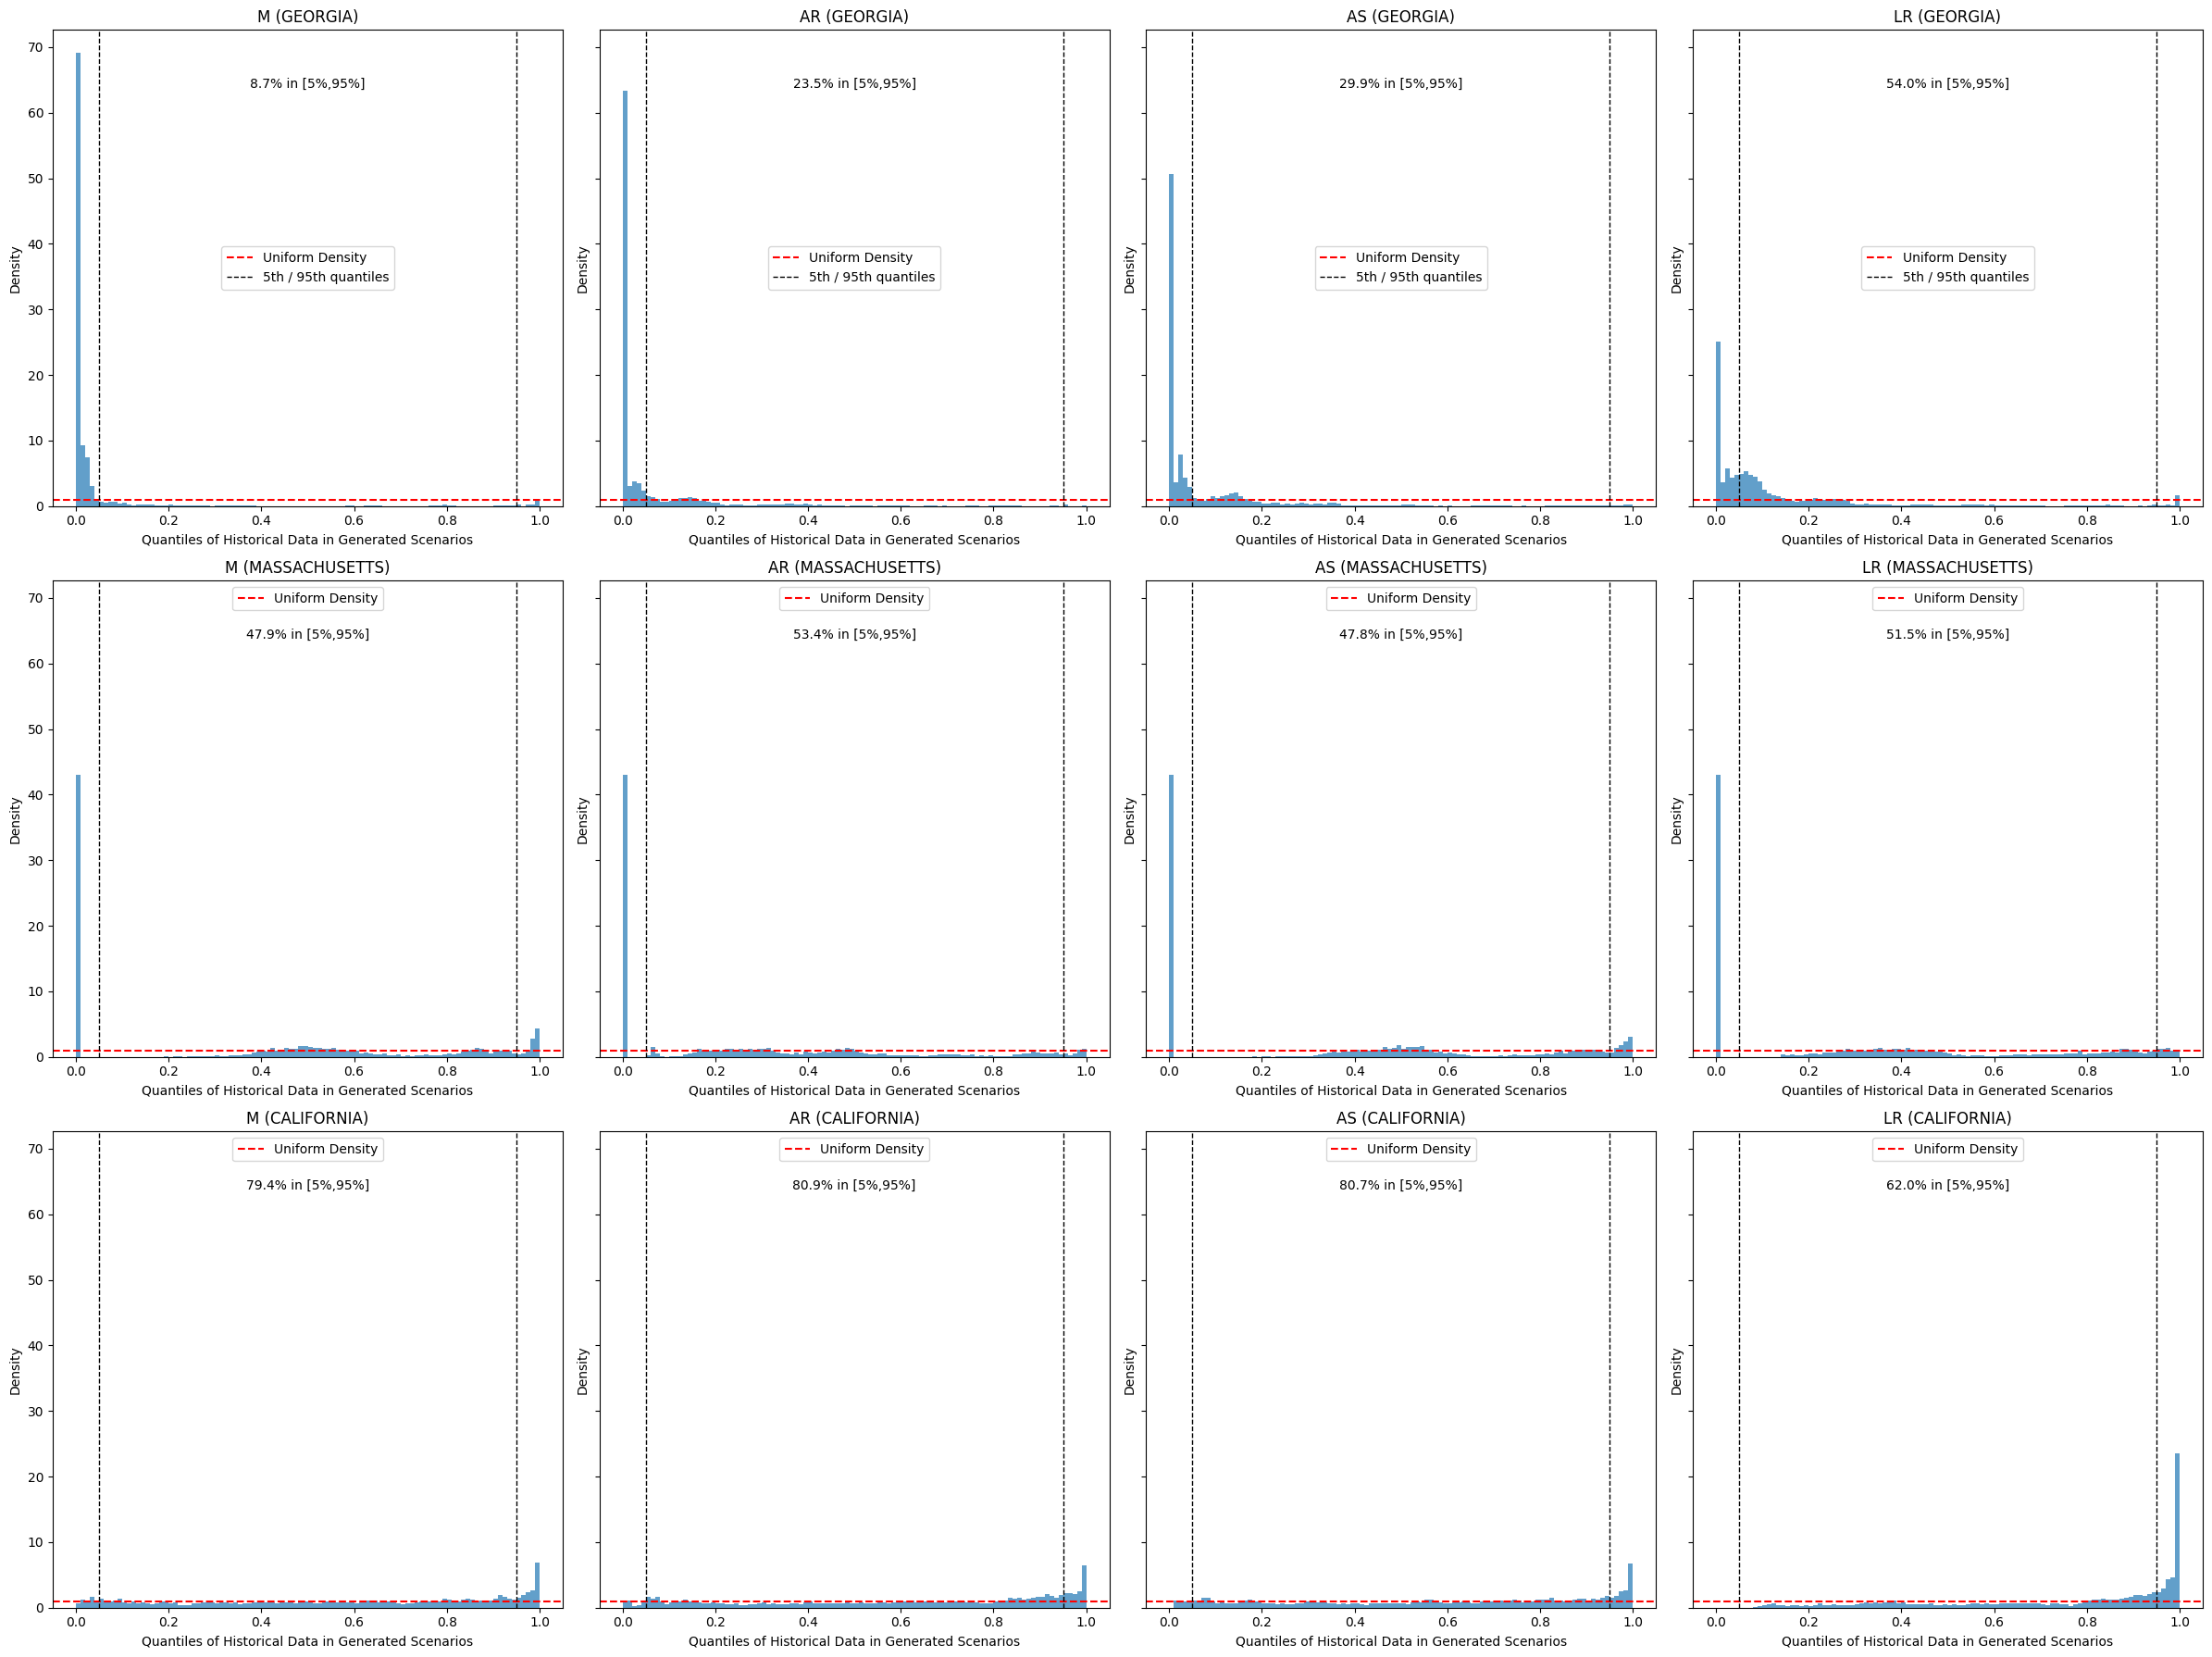

In [32]:
n_cols = len(models2evaluate)
n_rows = len(states_to_plot)
# n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), sharey=True)

for j, state in enumerate(states_to_plot):
    for i, (model_name, scenarios_model) in enumerate(generated_scenarios_by_state.items()):
        scenarios = scenarios_model[state]
        print(f"Evaluating model performance for state: {state}, model: {model_name}")

        historical_scenario = historical_scenario_by_state[state]

        # --- 1) Common time axis (assumes all scenarios share same grid) ---
        datetimes = scenarios[0]['Datetime_UTC'].to_numpy()

        # Align historical series on that axis
        hist_series = (
            historical_scenario
            .set_index('Datetime_UTC')
            .reindex(datetimes)['Unavailable_capacity (%)']
        )
        hist = hist_series.to_numpy(dtype=float)   # shape (T,)

        # --- 2) Build scenario matrix gen_matrix: shape (T, S) ---
        gen_matrix = np.stack([
            scen.set_index('Datetime_UTC')
                .reindex(datetimes)['Unavailable_capacity (%)']
                .to_numpy(dtype=float)
            for scen in scenarios
        ], axis=1)  # (T, S)

        # --- 3) Drop any timesteps with NaNs ---
        valid_mask = ~np.isnan(hist) & ~np.any(np.isnan(gen_matrix), axis=1)
        hist_valid = hist[valid_mask]
        gen_valid = gen_matrix[valid_mask, :]     # (T_valid, S)

        if hist_valid.size == 0:
            print(f"No valid timesteps for state={state}, model={model_name}; skipping.")
            continue

        # --- 4) Quantiles of historical in scenario distribution ---
        S = gen_valid.shape[1]
        model_quantiles = (gen_valid < hist_valid[:, None]).sum(axis=1) / S  # (T_valid,)

        # --- 5) Plot histogram ---
        ax = axs[j, i]

        ax.hist(
            model_quantiles,
            bins=100,
            range=(0, 1),
            color='tab:blue',
            alpha=0.7,
            density=True
        )
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Quantiles of Historical Data in Generated Scenarios')
        ax.set_ylabel('Density')
        ax.axhline(y=1, color='red', linestyle='--', label='Uniform Density')

        # --- 6) 5th & 95th quantiles + coverage text ---
        # q05 = np.quantile(model_quantiles, 0.05)
        # q95 = np.quantile(model_quantiles, 0.95)
        q05 = 0.05
        q95 = 0.95
        coverage = np.mean((model_quantiles >= q05) & (model_quantiles <= q95))

        # vertical lines
        ax.axvline(q05, color='black', linestyle='--', linewidth=1, label='5th / 95th quantiles' if j == 0 else None)
        ax.axvline(q95, color='black', linestyle='--', linewidth=1)

        # place text roughly near top between the two lines
        ymin, ymax = ax.get_ylim()
        x_mid = 0.5 * (q05 + q95)
        ax.text(
            x_mid,
            ymax * 0.9,
            f"{coverage*100:.1f}% in [5%,95%]",
            ha='center',
            va='top',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
        )

        ax.legend(loc='best')

plt.tight_layout()

In [33]:
unconditional_quant_cov_results = {'State':[], 'Model':[], 'Quantile_coverage':[]}
for model_name, scenarios_model in generated_scenarios_by_state.items():
    for state in tqdm(scenarios_model.keys(), desc=f"Unconditional quantile coverage for model {model_name}"):
        scenarios = scenarios_model[state]
        historical_scenario = historical_scenario_by_state[state]

        quantile_cov = quantile_coverage(historical_scenario, scenarios)

        unconditional_quant_cov_results['State'].append(state)
        unconditional_quant_cov_results['Model'].append(model_name)
        unconditional_quant_cov_results['Quantile_coverage'].append(quantile_cov)

Unconditional quantile coverage for model LR: 100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


In [34]:
unconditional_quant_cov_results = pd.DataFrame(unconditional_quant_cov_results)


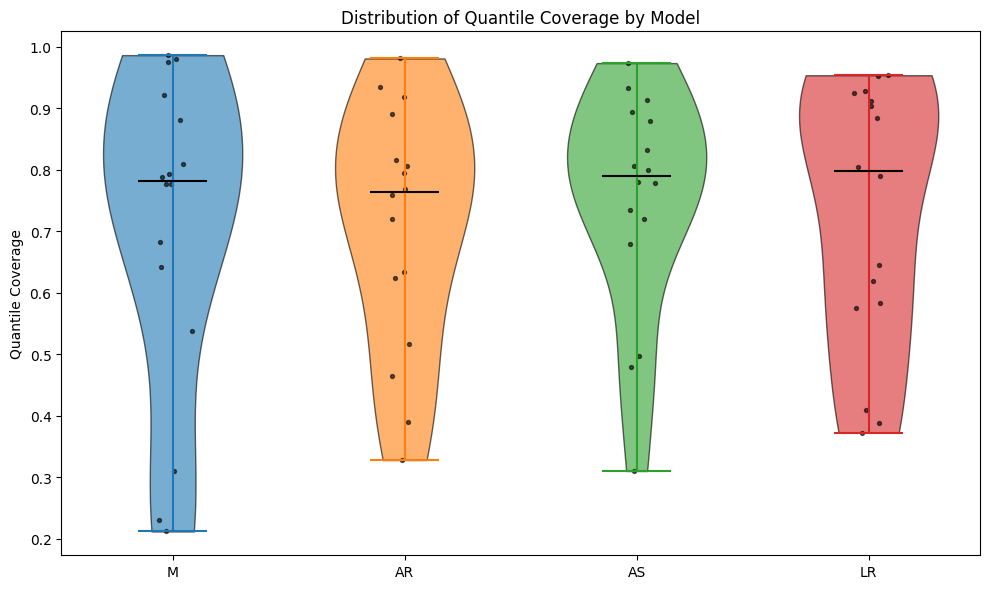

In [35]:

fig, ax = plt.subplots(figsize=(10,6))

for i, model_name in enumerate(models2evaluate.keys()):
    quant_cov_model = unconditional_quant_cov_results.loc[unconditional_quant_cov_results['Model'] == model_name, 'Quantile_coverage'].values
    if len(quant_cov_model) == 0:
        continue

    parts = ax.violinplot(quant_cov_model, positions=[i], widths=0.6, showmeans=False, showmedians=True)

    # style violin body
    for pc in parts['bodies']:
        pc.set_facecolor(plt.cm.tab10(i % 10))
        pc.set_edgecolor('black')
        pc.set_alpha(0.6)

    # median line color
    if 'cmedians' in parts:
        parts['cmedians'].set_color('black')

    # overlay individual points (jittered)
    x = np.random.normal(i, 0.04, size=len(ks_model))
    ax.scatter(x, quant_cov_model, color='k', s=8, alpha=0.6)

    # x ticks/labels and axis labels
    ax.set_xticks(list(range(len(models2evaluate))))
    ax.set_xticklabels(list(models2evaluate.keys()))
    ax.set_ylabel('Quantile Coverage')
    ax.set_title('Distribution of Quantile Coverage by Model')
    plt.tight_layout()

## Conditional distribution

In [36]:
temperature_bins_quantiles = {"Extreme Cold": (0, 0.01), "Cold": (0.01, 0.15), "Normal": (0.15, 0.85), "Hot": (0.85, 0.99), "Extreme Hot": (0.99, 1)}

In [37]:
conditional_ks_results = {'State':[], 'Model':[], 'Temp_bin': [], 'KS_statistic':[], 'p_value':[]}
conditional_quant_cov_results = {'State':[], 'Model':[], 'Temp_bin': [], 'Quantile_coverage':[]}


for model_name, scenarios_model in generated_scenarios_by_state.items():
    for state in tqdm(scenarios_model.keys(), desc=f"Conditional tests for model {model_name}"):
        for temp_bin, (lo_q, hi_q) in temperature_bins_quantiles.items():
            scenarios = scenarios_model[state]
            historical_scenario = historical_scenario_by_state[state]

            # --- 1) Common time axis (assumes all scenarios share same grid) ---
            datetimes = scenarios[0]['Datetime_UTC'].to_numpy()

            # Datetimes where temperature is in the bin
            inputs_df = scenarios_inputs_by_state[state]
            temp = inputs_df['Temperature'].to_numpy()
            low_temp = np.quantile(temp, lo_q)
            high_temp = np.quantile(temp, hi_q)
            temp_mask = (temp >= low_temp) & (temp <= high_temp)
            valid_datetimes = inputs_df['Datetime_UTC'].to_numpy()[temp_mask]

            # extract historical scenario for those datetimes
            historical_scenario_bin = historical_scenario[historical_scenario['Datetime_UTC'].isin(valid_datetimes)].copy()
            generated_scenarios_bin = []
            for scen in scenarios:
                scen_bin = scen[scen['Datetime_UTC'].isin(valid_datetimes)].copy()
                generated_scenarios_bin.append(scen_bin)

            # KS test
            ks_statistic, p_value = KS_test(historical_scenario_bin, generated_scenarios_bin)

            conditional_ks_results['State'].append(state)
            conditional_ks_results['Model'].append(model_name)
            conditional_ks_results['Temp_bin'].append(temp_bin)
            conditional_ks_results['KS_statistic'].append(ks_statistic)
            conditional_ks_results['p_value'].append(p_value)

            # Quantile coverage
            quantile_cov = quantile_coverage(historical_scenario_bin, generated_scenarios_bin)
            conditional_quant_cov_results['State'].append(state)
            conditional_quant_cov_results['Model'].append(model_name)
            conditional_quant_cov_results['Temp_bin'].append(temp_bin)
            conditional_quant_cov_results['Quantile_coverage'].append(quantile_cov)

Conditional tests for model LR: 100%|██████████| 16/16 [03:15<00:00, 12.20s/it]


In [38]:
conditional_ks_results = pd.DataFrame(conditional_ks_results)
conditional_quant_cov_results = pd.DataFrame(conditional_quant_cov_results)

### KS test

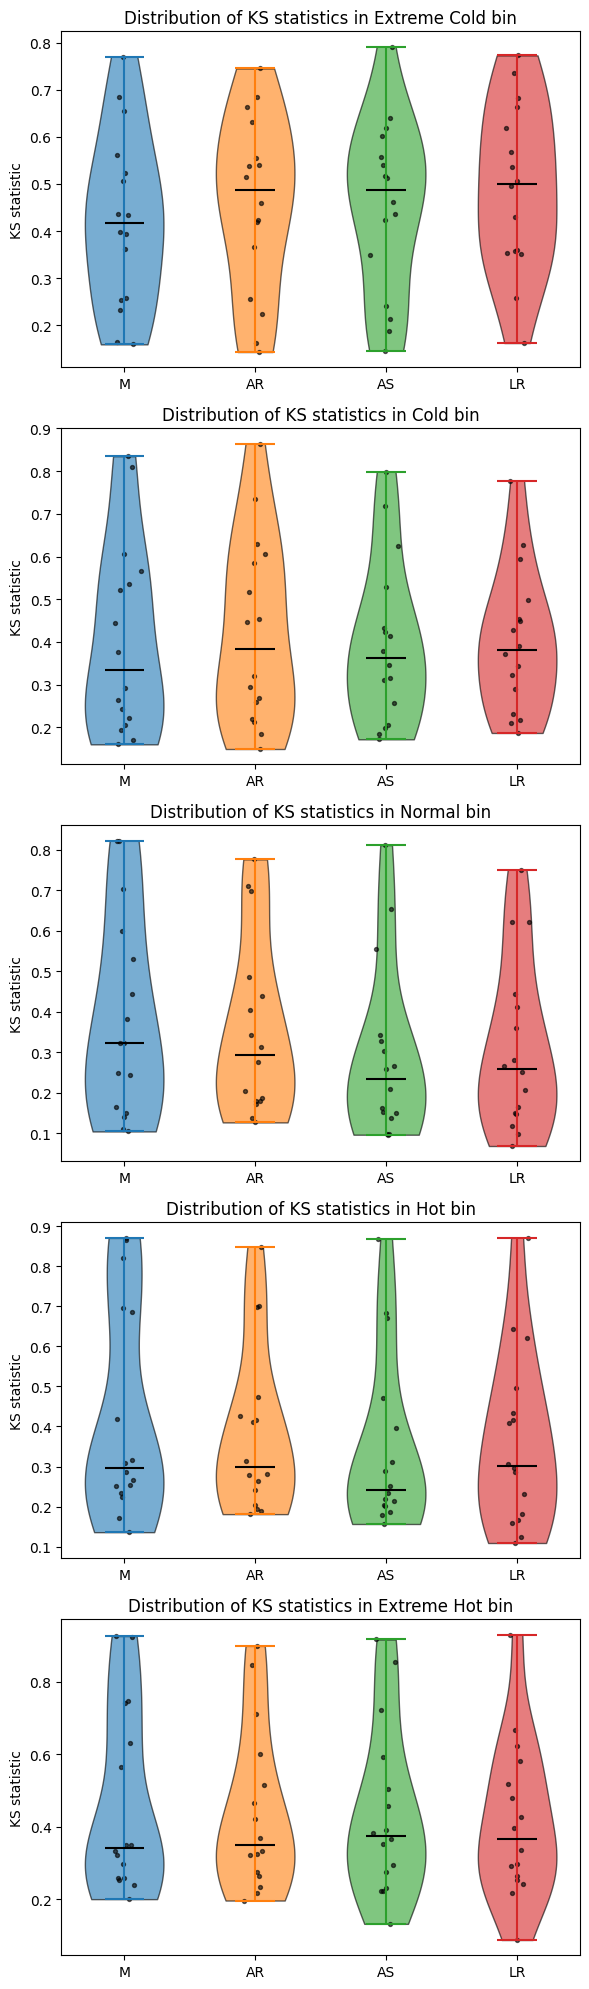

In [39]:

fig, axs = plt.subplots(len(temperature_bins_quantiles), 1, figsize=(6,20))

for i, (temp_bin, _) in enumerate(temperature_bins_quantiles.items()):
    ax = axs[i]
    for j, model_name in enumerate(models2evaluate.keys()):
        ks_model = conditional_ks_results.loc[(conditional_ks_results['Model'] == model_name) & (conditional_ks_results['Temp_bin'] == temp_bin), 'KS_statistic'].values
        if len(ks_model) == 0:
            continue

        parts = ax.violinplot(ks_model, positions=[j], widths=0.6, showmeans=False, showmedians=True)

        # style violin body
        for pc in parts['bodies']:
            pc.set_facecolor(plt.cm.tab10(j % 10))
            pc.set_edgecolor('black')
            pc.set_alpha(0.6)

        # median line color
        if 'cmedians' in parts:
            parts['cmedians'].set_color('black')

        # overlay individual points (jittered)
        x = np.random.normal(j, 0.04, size=len(ks_model))
        ax.scatter(x, ks_model, color='k', s=8, alpha=0.6)

    # x ticks/labels and axis labels
    ax.set_xticks(list(range(len(models2evaluate))))
    ax.set_xticklabels(list(models2evaluate.keys()))
    ax.set_ylabel('KS statistic')
    ax.set_title(f'Distribution of KS statistics in {temp_bin} bin')
    plt.tight_layout()

### Quantile coverage test

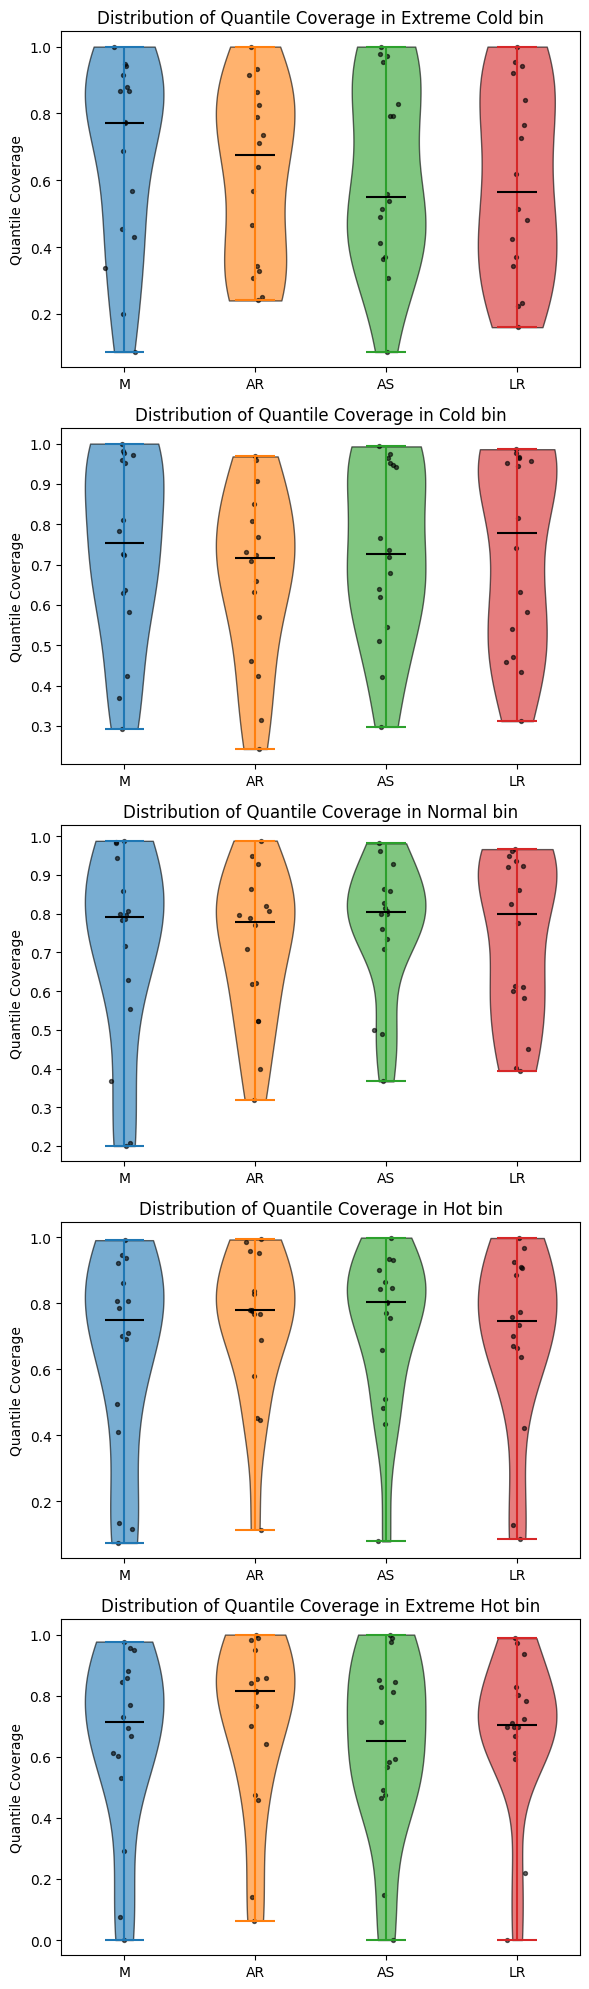

In [40]:

fig, axs = plt.subplots(len(temperature_bins_quantiles), 1, figsize=(6,20))

for i, (temp_bin, _) in enumerate(temperature_bins_quantiles.items()):
    ax = axs[i]
    for j, model_name in enumerate(models2evaluate.keys()):
        ks_model = conditional_quant_cov_results.loc[(conditional_quant_cov_results['Model'] == model_name) & (conditional_quant_cov_results['Temp_bin'] == temp_bin), 'Quantile_coverage'].values
        if len(ks_model) == 0:
            continue

        parts = ax.violinplot(ks_model, positions=[j], widths=0.6, showmeans=False, showmedians=True)

        # style violin body
        for pc in parts['bodies']:
            pc.set_facecolor(plt.cm.tab10(j % 10))
            pc.set_edgecolor('black')
            pc.set_alpha(0.6)

        # median line color
        if 'cmedians' in parts:
            parts['cmedians'].set_color('black')

        # overlay individual points (jittered)
        x = np.random.normal(j, 0.04, size=len(ks_model))
        ax.scatter(x, ks_model, color='k', s=8, alpha=0.6)

    # x ticks/labels and axis labels
    ax.set_xticks(list(range(len(models2evaluate))))
    ax.set_xticklabels(list(models2evaluate.keys()))
    ax.set_ylabel('Quantile Coverage')
    ax.set_title(f'Distribution of Quantile Coverage in {temp_bin} bin')
    plt.tight_layout()

## Temporal validation : persistance of threshold

In [41]:
def threshold_exceedance(time_series: pd.DataFrame, threshold: float, dt_col: str = "Datetime_UTC", val_col: str = "Unavailable_capacity (%)") -> int:
    ts = time_series[val_col].to_numpy()
    exceedance = np.array(ts > threshold, dtype=int)
    changes = np.diff(exceedance)

    taus = []
    for i in np.where(changes == 1)[0]:
        rm = np.where(changes[i+1:] == -1)[0]
        if len(rm) == 0:
            pass
        else:
            tau = rm[0] + 1
            taus.append(tau)
    return taus

    

In [42]:
q_gamma = [0.85, 0.9, 0.95, 0.99]

threshold_exceedance_taus = {} # threshold_exceedance_taus[exp_number] = experiment results
threshold_exceedance_exps = {"State":[], "Model":[], "Quantile":[], "Exp_num":[]}

exp_num = 1
for model_name, scenarios_model in generated_scenarios_by_state.items():
    for state in tqdm(scenarios_model.keys(), desc=f"Threshold exceedance analysis for model {model_name}"):
        for q in q_gamma:
            gen_val = np.concatenate([
                scen['Unavailable_capacity (%)'].to_numpy().flatten() 
                for scen in scenarios_model[state]
            ])
            threshold = np.quantile(gen_val, q)

            taus_gen = []
            for scen in scenarios_model[state]:
                taus_scen = threshold_exceedance(scen, threshold)
                taus_gen.extend(taus_scen)
            
            threshold_exceedance_exps["State"].append(state)
            threshold_exceedance_exps["Model"].append(model_name)
            threshold_exceedance_exps["Quantile"].append(q)
            threshold_exceedance_exps["Exp_num"].append(exp_num)

            threshold_exceedance_taus[exp_num] = taus_gen
            exp_num += 1


for state in tqdm(historical_scenario_by_state.keys(), desc="Threshold exceedance analysis for Historical model"):
    for q in q_gamma:
        historical_scenario = historical_scenario_by_state[state]
        if historical_scenario.empty:
            continue
        hist_val = historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten()
        threshold = np.quantile(hist_val, q)

        taus_hist = threshold_exceedance(historical_scenario, threshold)

        threshold_exceedance_exps["State"].append(state)
        threshold_exceedance_exps["Model"].append("Historical")
        threshold_exceedance_exps["Quantile"].append(q)
        threshold_exceedance_exps["Exp_num"].append(exp_num)

        threshold_exceedance_taus[exp_num] = taus_hist
        exp_num += 1

Threshold exceedance analysis for model LR: 100%|██████████| 16/16 [00:31<00:00,  1.94s/it]
Threshold exceedance analysis for Historical model: 100%|██████████| 55/55 [00:00<00:00, 948.10it/s]


In [43]:
threshold_exceedance_exps = pd.DataFrame(threshold_exceedance_exps)

In [44]:
threshold_exceedance_exps

,State,Model,Quantile,Exp_num
0,COLORADO,M,0.85,1
1,COLORADO,M,0.90,2
2,COLORADO,M,0.95,3
3,COLORADO,M,0.99,4
4,CONNECTICUT,M,0.85,5
...,...,...,...,...
451,VERMONT,Historical,0.99,452
452,MANITOBA,Historical,0.85,453
453,MANITOBA,Historical,0.90,454
454,MANITOBA,Historical,0.95,455


In [97]:
threshold_exceedance_exps

,State,Model,Quantile,Exp_num,KS_statistic,p_value
0,COLORADO,M,0.85,1,0.225233,0.001203
1,COLORADO,M,0.90,2,0.211551,0.007120
2,COLORADO,M,0.95,3,0.237539,0.018060
3,COLORADO,M,0.99,4,0.306392,0.064973
4,CONNECTICUT,M,0.85,5,0.248616,0.003733
...,...,...,...,...,...,...
451,VERMONT,Historical,0.99,452,NaN,NaN
452,MANITOBA,Historical,0.85,453,NaN,NaN
453,MANITOBA,Historical,0.90,454,NaN,NaN
454,MANITOBA,Historical,0.95,455,NaN,NaN


In [98]:
threshold_exceedance_exps['KS_statistic'] = np.nan
threshold_exceedance_exps['p_value'] = np.nan

for _, row_experiment in threshold_exceedance_exps.iterrows():
    model_name = row_experiment['Model']
    if model_name == "Historical":
        continue
    state = row_experiment['State']
    q = row_experiment['Quantile']

    exp_num = row_experiment['Exp_num']

    historical_exp_num = threshold_exceedance_exps.loc[
        (threshold_exceedance_exps['State'] == state) &
        (threshold_exceedance_exps['Model'] == "Historical") &
        (threshold_exceedance_exps['Quantile'] == q),
        'Exp_num'
    ].values[0]

    taus_gen = threshold_exceedance_taus[exp_num]
    taus_hist = threshold_exceedance_taus[historical_exp_num]


    statistic, p_value = ks_2samp(taus_hist, taus_gen)
    threshold_exceedance_exps.loc[
        threshold_exceedance_exps['Exp_num'] == exp_num,
        'KS_statistic'
    ] = statistic
    threshold_exceedance_exps.loc[
        threshold_exceedance_exps['Exp_num'] == exp_num,
        'p_value'
    ] = p_value

    if len(taus_hist) == 0 or len(taus_gen) == 0:
        print(f"Warning: No exceedance events for state={state}, model={model_name}, quantile={q}")
        print(statistic, p_value)



/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_69009/1732383279.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value = ks_2samp(taus_hist, taus_gen)


nan nan


/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_69009/1732383279.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value = ks_2samp(taus_hist, taus_gen)


nan nan


/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_69009/1732383279.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value = ks_2samp(taus_hist, taus_gen)


nan nan


/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_69009/1732383279.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, p_value = ks_2samp(taus_hist, taus_gen)


nan nan


(array([5.99100341e-02, 2.78075484e-02, 1.77856988e-02, 1.29913961e-02,
        8.04215181e-03, 6.68518056e-03, 5.38840948e-03, 4.54067253e-03,
        3.77386042e-03, 2.52840753e-03, 2.56590928e-03, 2.25701328e-03,
        2.00831745e-03, 1.35993192e-03, 1.48526672e-03, 1.34611548e-03,
        1.17341005e-03, 1.01846861e-03, 7.16480821e-04, 8.45763174e-04,
        7.43126802e-04, 6.64175748e-04, 5.03312974e-04, 5.37854060e-04,
        5.26011402e-04, 5.23050737e-04, 3.92781497e-04, 3.25673101e-04,
        3.74030622e-04, 3.17777995e-04, 2.92118902e-04, 2.05272742e-04,
        2.36853164e-04, 2.59551592e-04, 2.07246519e-04, 1.90469419e-04,
        1.27308576e-04, 1.51980780e-04, 1.43098787e-04, 1.55928333e-04,
        1.07570812e-04, 1.27308576e-04, 1.14479029e-04, 1.14479029e-04,
        8.48723838e-05, 8.38854956e-05, 8.88199365e-05, 7.40166138e-05,
        5.03312974e-05, 4.34230801e-05, 6.61215083e-05, 5.52657383e-05,
        5.23050737e-05, 5.82264028e-05, 4.04624155e-05, 4.934440

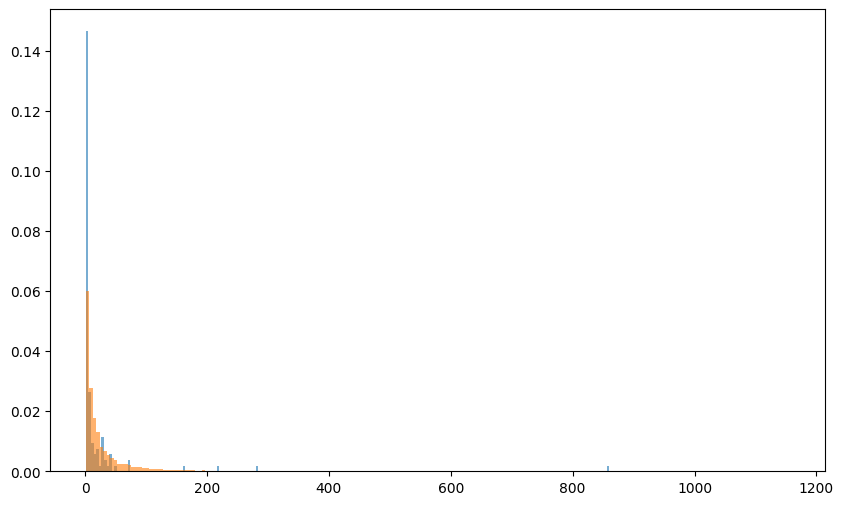

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
state = 'CALIFORNIA'
q = 0.85
model = 'M'

historical_exp_num = threshold_exceedance_exps.loc[(threshold_exceedance_exps['State'] == state) & 
                                                    (threshold_exceedance_exps['Model'] == 'Historical') & 
                                                    (threshold_exceedance_exps['Quantile'] == q), 'Exp_num'].values[0]
historical_taus = threshold_exceedance_taus[historical_exp_num]

gen_exp_num = threshold_exceedance_exps.loc[(threshold_exceedance_exps['State'] == state) & 
                                            (threshold_exceedance_exps['Model'] == model) & 
                                            (threshold_exceedance_exps['Quantile'] == q), 'Exp_num'].values[0]
generated_taus = threshold_exceedance_taus[gen_exp_num]

ax.hist(historical_taus, bins=200, alpha=0.6, label='Historical', color='tab:blue', density=True)
ax.hist(generated_taus, bins=200, alpha=0.6, label=model, color='tab:orange', density=True)

# Performance comparison summary

### Weighted average of performances (number of generators per state)

In [80]:
num_gen_state = {}
for state, gen_state in generators_per_state.items():
    df = gen_state.loc[gen_state['Technology'].isin(technologies)].copy()
    num_gen_state[state] = len(df)

In [81]:
unconditional_ks_results

,State,Model,KS_statistic,p_value
0,COLORADO,M,0.176013,0.000000e+00
1,CONNECTICUT,M,0.584240,0.000000e+00
2,ILLINOIS,M,0.634032,0.000000e+00
3,IOWA,M,0.317142,0.000000e+00
4,KENTUCKY,M,0.243764,0.000000e+00
...,...,...,...,...
59,KANSAS,LR,0.319916,0.000000e+00
60,ARKANSAS,LR,0.142405,3.064108e-310
61,IDAHO,LR,0.150470,0.000000e+00
62,INDIANA,LR,0.169829,0.000000e+00


In [109]:
weighted_average_performance = {'Test':[], **{model_name: [] for model_name in models2evaluate.keys()}}
weighted_median_performance = {'Test':[], **{model_name: [] for model_name in models2evaluate.keys()}}

# Unconditional KS test
weighted_average_performance['Test'].append('Unconditional KS')
weighted_median_performance['Test'].append('Unconditional KS')
for model_name in unconditional_ks_results['Model'].unique():
    model_ks = unconditional_ks_results.loc[unconditional_ks_results['Model'] == model_name].copy()
    model_ks['Num_gen'] = model_ks['State'].apply(lambda x: num_gen_state.get(x, 0))
    weighted_avg_ks = np.average(model_ks['KS_statistic'], weights=model_ks['Num_gen'])
    weighted_average_performance[model_name].append(weighted_avg_ks)

    weighted_median_ks = np.quantile(model_ks['KS_statistic'], q=0.5, method='inverted_cdf', weights=model_ks['Num_gen'])
    weighted_median_performance[model_name].append(weighted_median_ks)


# Unconditional Quantile Coverage
weighted_average_performance['Test'].append('Unconditional Quantile Coverage')
weighted_median_performance['Test'].append('Unconditional Quantile Coverage')
for model_name in unconditional_quant_cov_results['Model'].unique():
    model_qc = unconditional_quant_cov_results.loc[unconditional_quant_cov_results['Model'] == model_name].copy()
    model_qc['Num_gen'] = model_qc['State'].apply(lambda x: num_gen_state.get(x, 0))
    weighted_avg_qc = np.average(model_qc['Quantile_coverage'], weights=model_qc['Num_gen'])
    weighted_average_performance[model_name].append(weighted_avg_qc)

    weighted_median_qc = np.quantile(model_qc['Quantile_coverage'], q=0.5, method='inverted_cdf', weights=model_qc['Num_gen'])
    weighted_median_performance[model_name].append(weighted_median_qc)

    
# Conditional KS test
for temp_bin, _ in temperature_bins_quantiles.items():
    weighted_average_performance['Test'].append(f'Conditional KS ({temp_bin})')
    weighted_median_performance['Test'].append(f'Conditional KS ({temp_bin})')
    for model_name in conditional_ks_results['Model'].unique():
        model_ks = conditional_ks_results.loc[(conditional_ks_results['Model'] == model_name) & (conditional_ks_results['Temp_bin'] == temp_bin)].copy()
        model_ks['Num_gen'] = model_ks['State'].apply(lambda x: num_gen_state.get(x, 0))
        weighted_avg_ks = np.average(model_ks['KS_statistic'], weights=model_ks['Num_gen'])
        weighted_average_performance[model_name].append(weighted_avg_ks)

        weighted_median_ks = np.quantile(model_ks['KS_statistic'], q=0.5, method='inverted_cdf', weights=model_ks['Num_gen'])
        weighted_median_performance[model_name].append(weighted_median_ks)

# Conditional Quantile Coverage
for temp_bin, _ in temperature_bins_quantiles.items():
    weighted_average_performance['Test'].append(f'Conditional Quantile Coverage ({temp_bin})')
    weighted_median_performance['Test'].append(f'Conditional Quantile Coverage ({temp_bin})')
    for model_name in conditional_quant_cov_results['Model'].unique():
        model_qc = conditional_quant_cov_results.loc[(conditional_quant_cov_results['Model'] == model_name) & (conditional_quant_cov_results['Temp_bin'] == temp_bin)].copy()
        model_qc['Num_gen'] = model_qc['State'].apply(lambda x: num_gen_state.get(x, 0))
        weighted_avg_qc = np.average(model_qc['Quantile_coverage'], weights=model_qc['Num_gen'])
        weighted_average_performance[model_name].append(weighted_avg_qc)

        weighted_median_qc = np.quantile(model_qc['Quantile_coverage'], q=0.5, method='inverted_cdf', weights=model_qc['Num_gen'])
        weighted_median_performance[model_name].append(weighted_median_qc)


# Persistence of threshold exceedance taus
for quantile in threshold_exceedance_exps['Quantile'].unique():
    weighted_average_performance['Test'].append(f'THP KS q={quantile}')
    weighted_median_performance['Test'].append(f'THP KS q={quantile}')
    for model_name in threshold_exceedance_exps['Model'].unique():
        if model_name == "Historical":
            continue
        model_ks = threshold_exceedance_exps.loc[(threshold_exceedance_exps['Model'] == model_name)&(threshold_exceedance_exps['Quantile'] == quantile)].copy()
        model_ks.dropna(subset=['KS_statistic'], inplace=True)
        model_ks['Num_gen'] = model_ks['State'].apply(lambda x: num_gen_state.get(x, 0))
        weighted_avg_ks = np.average(model_ks['KS_statistic'], weights=model_ks['Num_gen'])
        weighted_average_performance[model_name].append(weighted_avg_ks)

        weighted_median_ks = np.quantile(model_ks['KS_statistic'], q=0.5, method='inverted_cdf', weights=model_ks['Num_gen'])
        weighted_median_performance[model_name].append(weighted_median_ks)


weighted_average_performance = pd.DataFrame(weighted_average_performance)
weighted_median_performance = pd.DataFrame(weighted_median_performance)

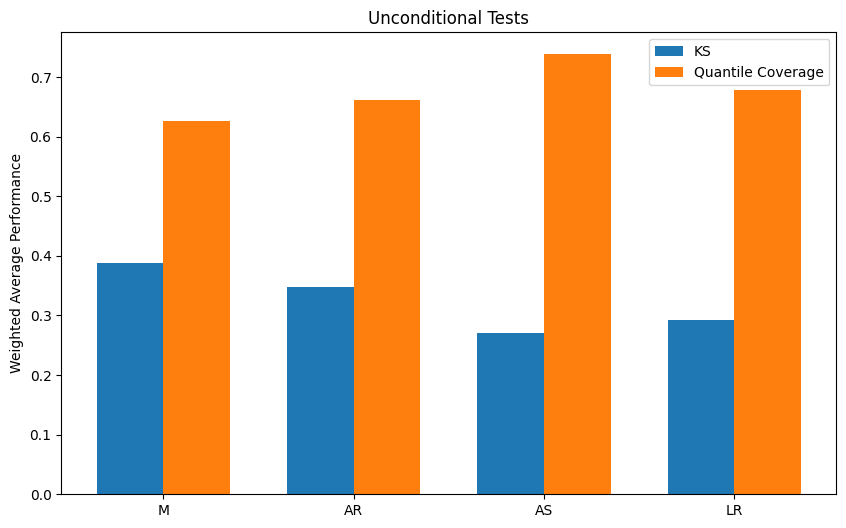

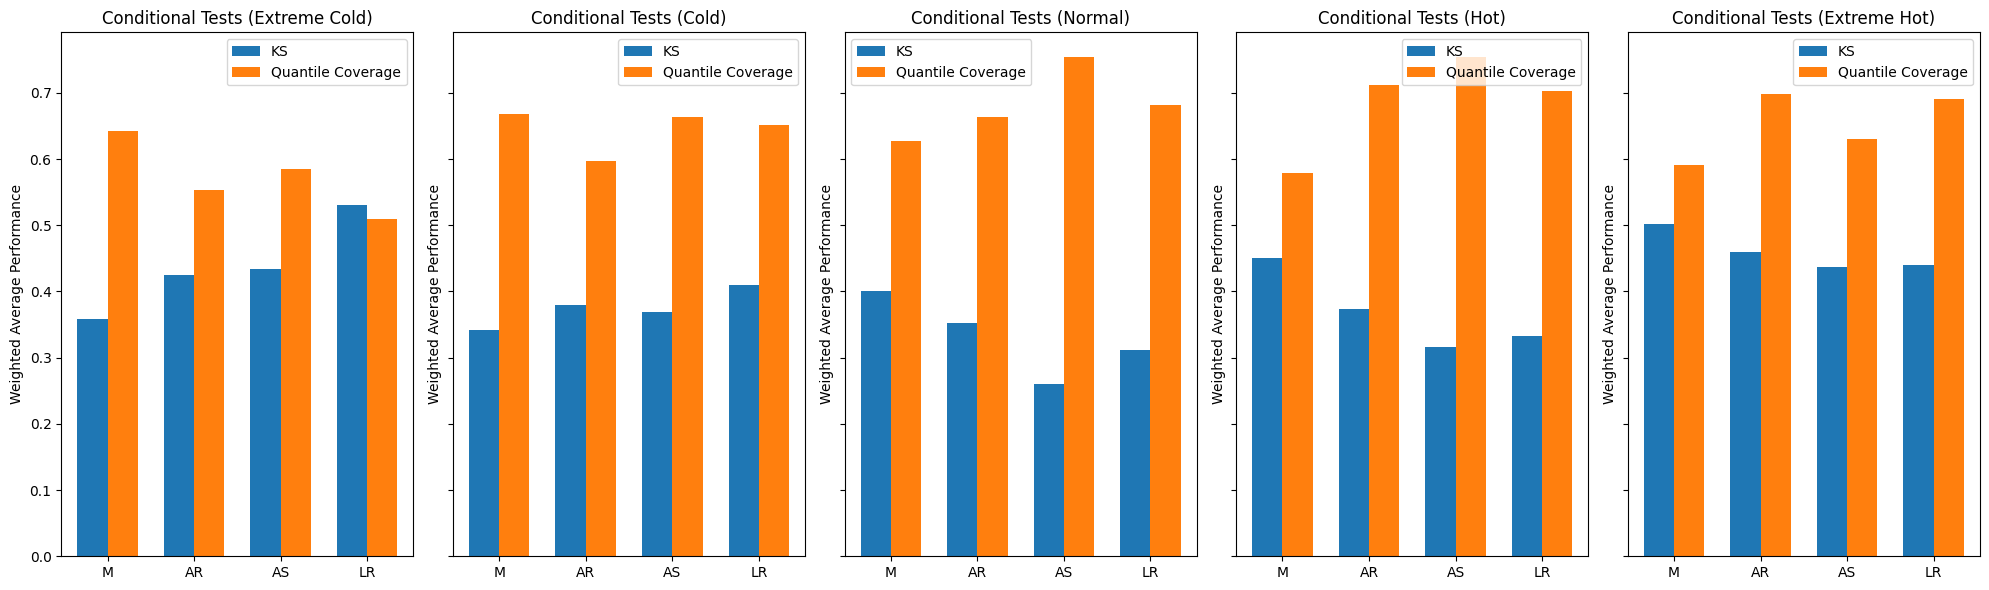

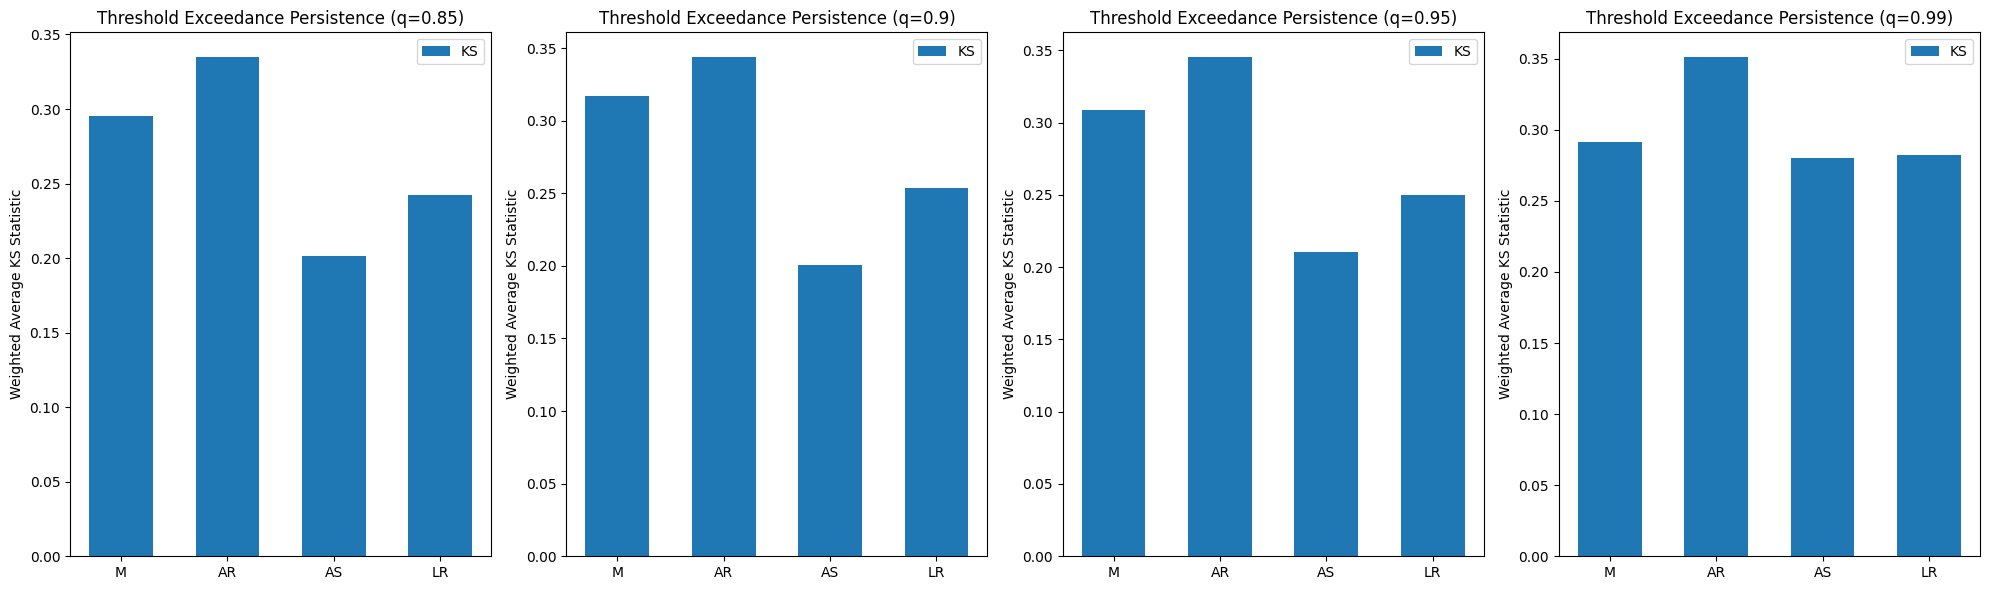

In [111]:
# Unconditional tests
fig, ax = plt.subplots(figsize=(10,6))
ks_unconditional = weighted_average_performance.loc[weighted_average_performance['Test'] == 'Unconditional KS']
qc_unconditional = weighted_average_performance.loc[weighted_average_performance['Test'] == 'Unconditional Quantile Coverage']
x = np.arange(len(models2evaluate))
width = 0.35
bars1 = ax.bar(x - width/2, ks_unconditional.iloc[0,1:], width, label='KS')
bars2 = ax.bar(x + width/2, qc_unconditional.iloc[0,1:], width, label='Quantile Coverage')
ax.set_xticks(x)
ax.set_xticklabels(models2evaluate.keys())
ax.set_ylabel('Weighted Average Performance')
ax.set_title('Unconditional Tests')
ax.legend()
plt.show()

# Conditional tests
fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=True)
ks_conditional = weighted_average_performance.loc[weighted_average_performance['Test'].str.contains('Conditional KS')]
qc_conditional = weighted_average_performance.loc[weighted_average_performance['Test'].str.contains('Conditional Quantile Coverage')]
for i, temp_bin in enumerate(temperature_bins_quantiles.keys()):
    ax = axs[i]
    ks_temp = ks_conditional.loc[ks_conditional['Test'] == f'Conditional KS ({temp_bin})']
    qc_temp = qc_conditional.loc[qc_conditional['Test'] == f'Conditional Quantile Coverage ({temp_bin})']
    x = np.arange(len(models2evaluate))
    width = 0.35
    bars1 = ax.bar(x - width/2, ks_temp.iloc[0,1:], width, label='KS')
    bars2 = ax.bar(x + width/2, qc_temp.iloc[0,1:], width, label='Quantile Coverage')
    ax.set_xticks(x)
    ax.set_xticklabels(models2evaluate.keys())
    ax.set_ylabel('Weighted Average Performance')
    ax.set_title(f'Conditional Tests ({temp_bin})')
    ax.legend()
plt.tight_layout()
plt.show()

# Persistence of threshold exceedance taus
fig, ax = plt.subplots(1, len(q_gamma), figsize=(20,6))
for i, quantile in enumerate(q_gamma):
    ax_i = ax[i] if len(q_gamma) > 1 else ax
    thp_ks = weighted_average_performance.loc[weighted_average_performance['Test'] == f'THP KS q={quantile}']
    x = np.arange(len(models2evaluate))
    bars = ax_i.bar(x, thp_ks.iloc[0,1:], width=0.6, label='KS')
    ax_i.set_xticks(x)
    ax_i.set_xticklabels(models2evaluate.keys())
    ax_i.set_ylabel('Weighted Average KS Statistic')
    ax_i.set_title(f'Threshold Exceedance Persistence (q={quantile})')
    ax_i.legend()
plt.tight_layout()
plt.show()

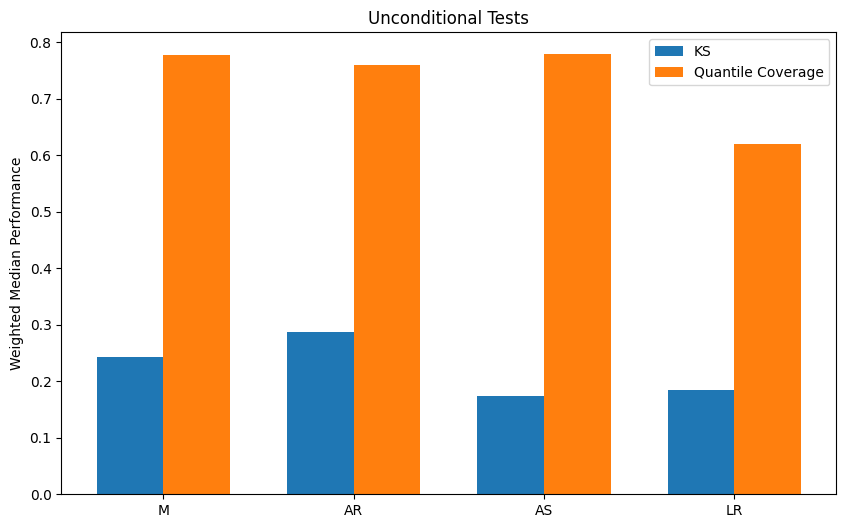

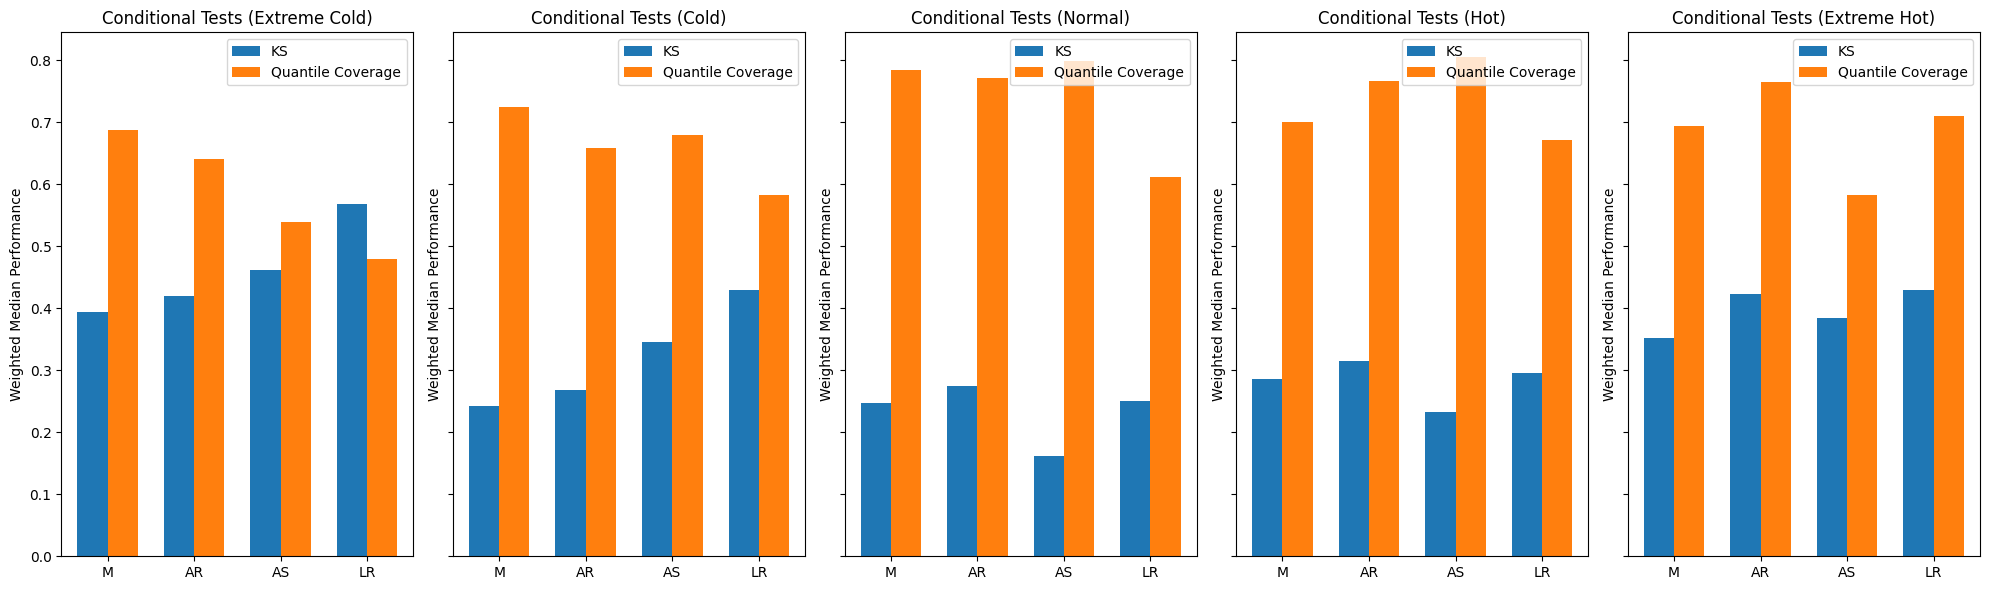

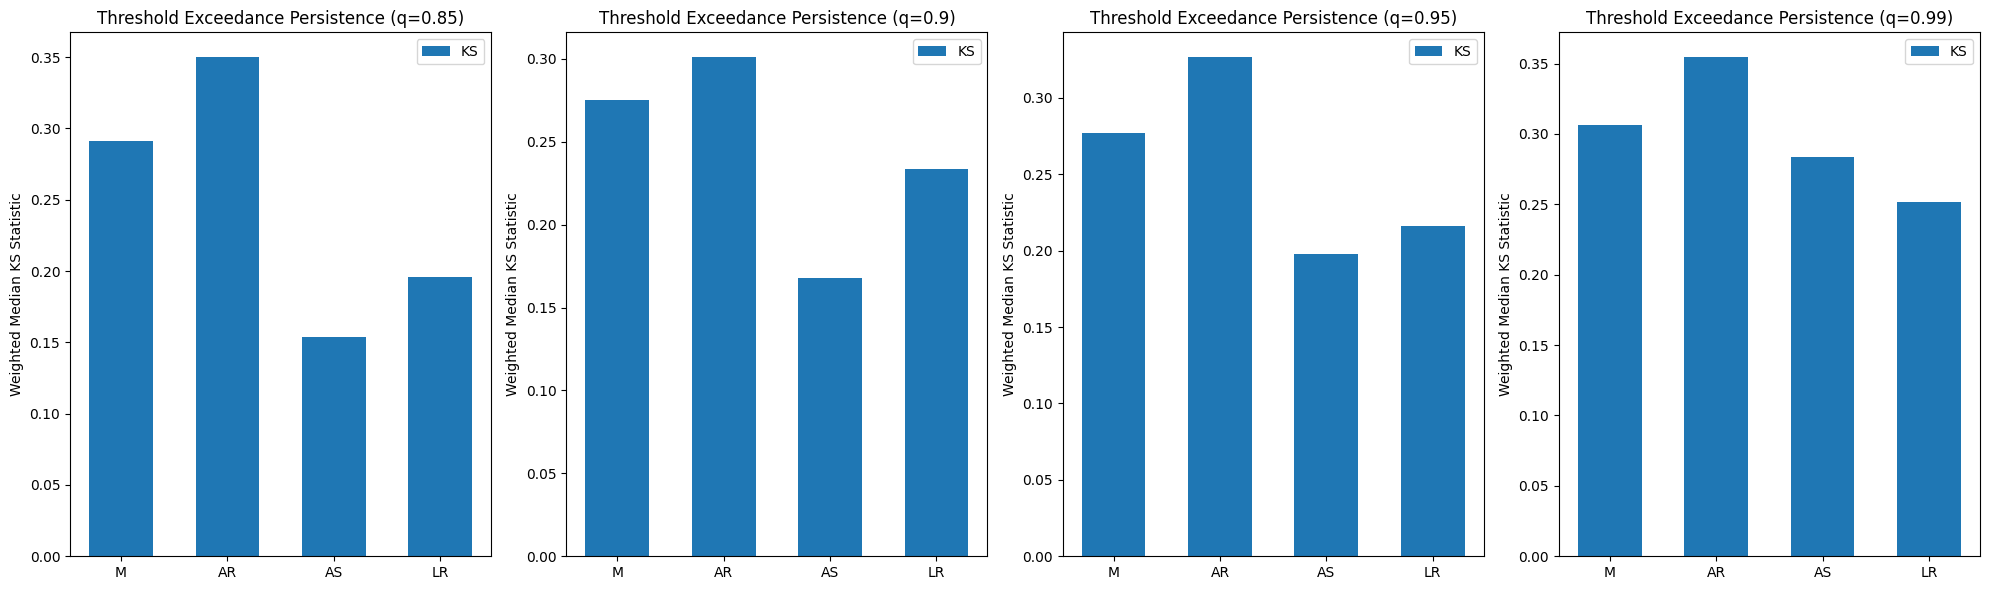

In [112]:
# Unconditional tests
fig, ax = plt.subplots(figsize=(10,6))
ks_unconditional = weighted_median_performance.loc[weighted_median_performance['Test'] == 'Unconditional KS']
qc_unconditional = weighted_median_performance.loc[weighted_median_performance['Test'] == 'Unconditional Quantile Coverage']
x = np.arange(len(models2evaluate))
width = 0.35
bars1 = ax.bar(x - width/2, ks_unconditional.iloc[0,1:], width, label='KS')
bars2 = ax.bar(x + width/2, qc_unconditional.iloc[0,1:], width, label='Quantile Coverage')
ax.set_xticks(x)
ax.set_xticklabels(models2evaluate.keys())
ax.set_ylabel('Weighted Median Performance')
ax.set_title('Unconditional Tests')
ax.legend()
plt.show()

# Conditional tests
fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=True)
ks_conditional = weighted_median_performance.loc[weighted_median_performance['Test'].str.contains('Conditional KS')]
qc_conditional = weighted_median_performance.loc[weighted_median_performance['Test'].str.contains('Conditional Quantile Coverage')]
for i, temp_bin in enumerate(temperature_bins_quantiles.keys()):
    ax = axs[i]
    ks_temp = ks_conditional.loc[ks_conditional['Test'] == f'Conditional KS ({temp_bin})']
    qc_temp = qc_conditional.loc[qc_conditional['Test'] == f'Conditional Quantile Coverage ({temp_bin})']
    x = np.arange(len(models2evaluate))
    width = 0.35
    bars1 = ax.bar(x - width/2, ks_temp.iloc[0,1:], width, label='KS')
    bars2 = ax.bar(x + width/2, qc_temp.iloc[0,1:], width, label='Quantile Coverage')
    ax.set_xticks(x)
    ax.set_xticklabels(models2evaluate.keys())
    ax.set_ylabel('Weighted Median Performance')
    ax.set_title(f'Conditional Tests ({temp_bin})')
    ax.legend()
plt.tight_layout()
plt.show()

# Persistence of threshold exceedance taus
fig, ax = plt.subplots(1, len(q_gamma), figsize=(20,6))
for i, quantile in enumerate(q_gamma):
    ax_i = ax[i] if len(q_gamma) > 1 else ax
    thp_ks = weighted_median_performance.loc[weighted_median_performance['Test'] == f'THP KS q={quantile}']
    x = np.arange(len(models2evaluate))
    bars = ax_i.bar(x, thp_ks.iloc[0,1:], width=0.6, label='KS')
    ax_i.set_xticks(x)
    ax_i.set_xticklabels(models2evaluate.keys())
    ax_i.set_ylabel('Weighted Median KS Statistic')
    ax_i.set_title(f'Threshold Exceedance Persistence (q={quantile})')
    ax_i.legend()
plt.tight_layout()
plt.show()

### Ratio of states it performs best

In [65]:
states_performs_best = {'Test':[], **{model_name: [] for model_name in models2evaluate.keys()}}

# Unconditional KS test
best_model_counts = {model_name: 0 for model_name in models2evaluate.keys()}
for state in unconditional_ks_results['State'].unique():
    state_ks = unconditional_ks_results.loc[unconditional_ks_results['State'] == state]
    best_model = state_ks.loc[state_ks['KS_statistic'].idxmin()]['Model']
    best_model_counts[best_model] += 1
states_performs_best['Test'].append('Unconditional KS')
for model_name, count in best_model_counts.items():
    states_performs_best[model_name].append(count)


# Unconditional Quantile Coverage
best_model_counts = {model_name: 0 for model_name in models2evaluate.keys()}
for state in unconditional_quant_cov_results['State'].unique():
    state_qc = unconditional_quant_cov_results.loc[unconditional_quant_cov_results['State'] == state].copy()
    state_qc['Quantile_coverage'].apply(lambda x: np.abs(x-90))
    best_model = state_qc.loc[state_qc['Quantile_coverage'].idxmin()]['Model']
    best_model_counts[best_model] += 1
states_performs_best['Test'].append('Unconditional Quantile Coverage')
for model_name, count in best_model_counts.items():
    states_performs_best[model_name].append(count)

# Conditional KS test
for temp_bin, _ in temperature_bins_quantiles.items():
    best_model_counts = {model_name: 0 for model_name in models2evaluate.keys()}
    for state in conditional_ks_results['State'].unique():
        state_ks = conditional_ks_results.loc[(conditional_ks_results['State'] == state) & (conditional_ks_results['Temp_bin'] == temp_bin)]
        if state_ks.empty:
            continue
        best_model = state_ks.loc[state_ks['KS_statistic'].idxmin()]['Model']
        best_model_counts[best_model] += 1
    states_performs_best['Test'].append(f'Conditional KS ({temp_bin})')
    for model_name, count in best_model_counts.items():
        states_performs_best[model_name].append(count)

# Conditional Quantile Coverage
for temp_bin, _ in temperature_bins_quantiles.items():
    best_model_counts = {model_name: 0 for model_name in models2evaluate.keys()}
    for state in conditional_quant_cov_results['State'].unique():
        state_qc = conditional_quant_cov_results.loc[(conditional_quant_cov_results['State'] == state) & (conditional_quant_cov_results['Temp_bin'] == temp_bin)]
        if state_qc.empty:
            continue
        state_qc['Quantile_coverage'].apply(lambda x: np.abs(x-90))
        best_model = state_qc.loc[state_qc['Quantile_coverage'].idxmin()]['Model']
        best_model_counts[best_model] += 1
    states_performs_best['Test'].append(f'Conditional Quantile Coverage ({temp_bin})')
    for model_name, count in best_model_counts.items():
        states_performs_best[model_name].append(count)

states_performs_best = pd.DataFrame(states_performs_best)

In [66]:
states_performs_best

,Test,M,AR,AS,LR
0,Unconditional KS,3,2,2,9
1,Unconditional Quantile Coverage,3,4,2,7
2,Conditional KS (Extreme Cold),4,6,1,5
3,Conditional KS (Cold),4,4,3,5
4,Conditional KS (Normal),3,2,5,6
5,Conditional KS (Hot),2,4,2,8
6,Conditional KS (Extreme Hot),4,2,2,8
7,Conditional Quantile Coverage (Extreme Cold),3,6,2,5
8,Conditional Quantile Coverage (Cold),1,8,2,5
9,Conditional Quantile Coverage (Normal),4,4,1,7


In [67]:
total_states = len(unconditional_ks_results['State'].unique())
states_performs_best[[model_name for model_name in models2evaluate.keys()]] /= total_states / 100


In [68]:
states_performs_best

,Test,M,AR,AS,LR
0,Unconditional KS,18.75,12.50,12.50,56.25
1,Unconditional Quantile Coverage,18.75,25.00,12.50,43.75
2,Conditional KS (Extreme Cold),25.00,37.50,6.25,31.25
3,Conditional KS (Cold),25.00,25.00,18.75,31.25
4,Conditional KS (Normal),18.75,12.50,31.25,37.50
5,Conditional KS (Hot),12.50,25.00,12.50,50.00
6,Conditional KS (Extreme Hot),25.00,12.50,12.50,50.00
7,Conditional Quantile Coverage (Extreme Cold),18.75,37.50,12.50,31.25
8,Conditional Quantile Coverage (Cold),6.25,50.00,12.50,31.25
9,Conditional Quantile Coverage (Normal),25.00,25.00,6.25,43.75


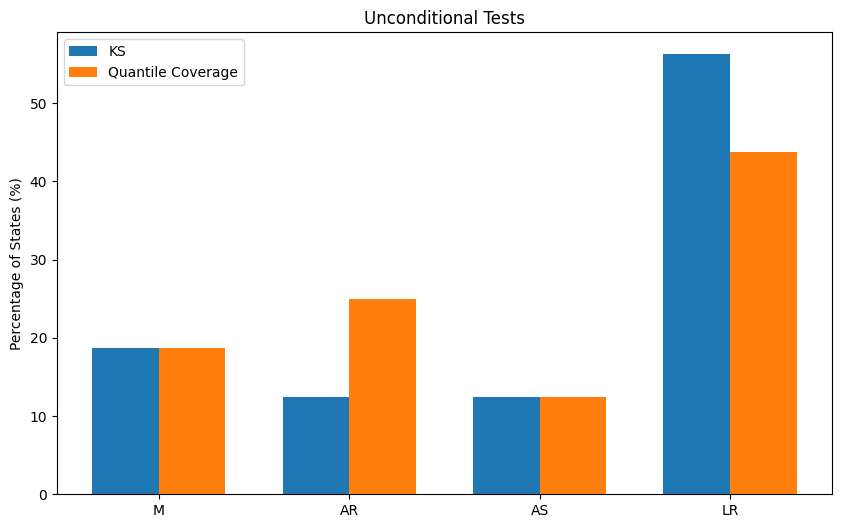

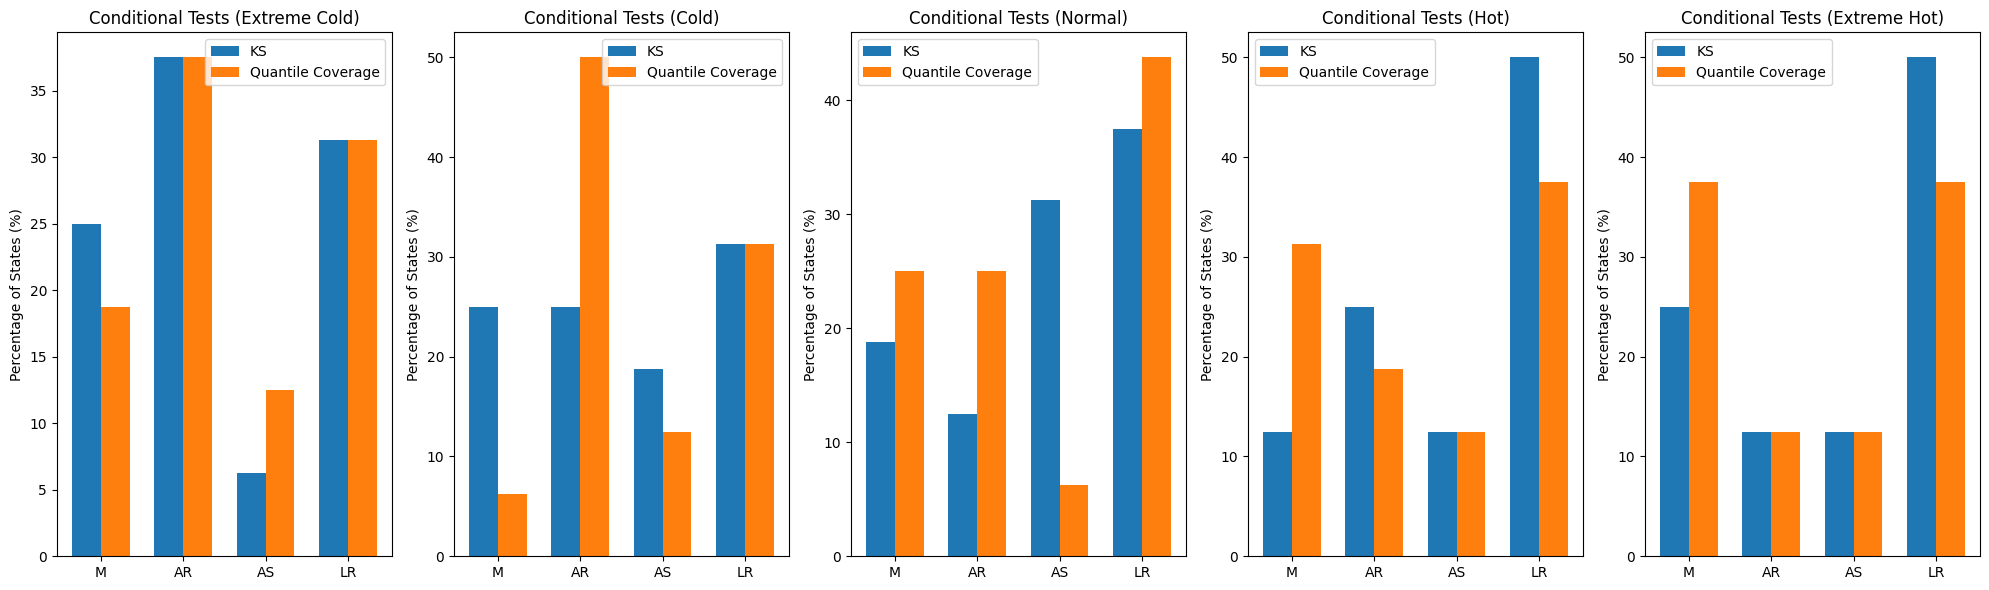

In [77]:
# Unconditional tests
fig, ax = plt.subplots(figsize=(10,6))
ks_unconditional = states_performs_best.loc[states_performs_best['Test'] == 'Unconditional KS']
qc_unconditional = states_performs_best.loc[states_performs_best['Test'] == 'Unconditional Quantile Coverage']
x = np.arange(len(models2evaluate))
width = 0.35
bars1 = ax.bar(x - width/2, ks_unconditional.iloc[0,1:], width, label='KS')
bars2 = ax.bar(x + width/2, qc_unconditional.iloc[0,1:], width, label='Quantile Coverage')
ax.set_xticks(x)
ax.set_xticklabels(models2evaluate.keys())
ax.set_ylabel('Percentage of States (%)')
ax.set_title('Unconditional Tests')
ax.legend()
plt.show()

# Conditional tests
fig, axs = plt.subplots(1, 5, figsize=(20, 6))
ks_conditional = states_performs_best.loc[states_performs_best['Test'].str.contains('Conditional KS')]
qc_conditional = states_performs_best.loc[states_performs_best['Test'].str.contains('Conditional Quantile Coverage')]
for i, temp_bin in enumerate(temperature_bins_quantiles.keys()):
    ax = axs[i]
    ks_temp = ks_conditional.loc[ks_conditional['Test'] == f'Conditional KS ({temp_bin})']
    qc_temp = qc_conditional.loc[qc_conditional['Test'] == f'Conditional Quantile Coverage ({temp_bin})']
    x = np.arange(len(models2evaluate))
    width = 0.35
    bars1 = ax.bar(x - width/2, ks_temp.iloc[0,1:], width, label='KS')
    bars2 = ax.bar(x + width/2, qc_temp.iloc[0,1:], width, label='Quantile Coverage')
    ax.set_xticks(x)
    ax.set_xticklabels(models2evaluate.keys())
    ax.set_ylabel('Percentage of States (%)')
    ax.set_title(f'Conditional Tests ({temp_bin})')
    ax.legend()
plt.tight_layout()
plt.show()